[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-4/research-assistant.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239974-lesson-4-research-assistant)

# Research Assistant

## Review

We've covered a few major LangGraph themes:

* Memory
* Human-in-the-loop
* Controllability

Now, we'll bring these ideas together to tackle one of AI's most popular applications: research automation. 

Research is often laborious work offloaded to analysts. AI has considerable potential to assist with this.

However, research demands customization: raw LLM outputs are often poorly suited for real-world decision-making workflows. 

Customized, AI-based [research and report generation](https://jxnl.co/writing/2024/06/05/predictions-for-the-future-of-rag/#reports-over-rag) workflows are a promising way to address this.

## Goal

Our goal is to build a lightweight, multi-agent system around chat models that customizes the research process.

`Source Selection` 
* Users can choose any set of input sources for their research.
  
`Planning` 
* Users provide a topic, and the system generates a team of AI analysts, each focusing on one sub-topic.
* `Human-in-the-loop` will be used to refine these sub-topics before research begins.
  
`LLM Utilization`
* Each analyst will conduct in-depth interviews with an expert AI using the selected sources.
* The interview will be a multi-turn conversation to extract detailed insights as shown in the [STORM](https://arxiv.org/abs/2402.14207) paper.
* These interviews will be captured in a using `sub-graphs` with their internal state. 
   
`Research Process`
* Experts will gather information to answer analyst questions in `parallel`.
* And all interviews will be conducted simultaneously through `map-reduce`.

`Output Format` 
* The gathered insights from each interview will be synthesized into a final report.
* We'll use customizable prompts for the report, allowing for a flexible output format. 

![Screenshot 2024-08-26 at 7.26.33 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb164d61c93d48e604091_research-assistant1.png)

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langchain_community langchain_core tavily-python wikipedia

## Setup

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [3]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o", temperature=0) 

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [4]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

## Generate Analysts: Human-In-The-Loop

Create analysts and review them using human-in-the-loop.

In [5]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

class Analyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the analyst.",
    )
    name: str = Field(
        description="Name of the analyst."
    )
    role: str = Field(
        description="Role of the analyst in the context of the topic.",
    )
    description: str = Field(
        description="Description of the analyst focus, concerns, and motives.",
    )
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        description="Comprehensive list of analysts with their roles and affiliations.",
    )

class GenerateAnalystsState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions

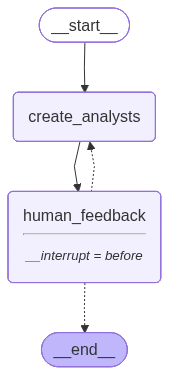

In [6]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

def create_analysts(state: GenerateAnalystsState):
    
    """ Create analysts """
    
    topic=state['topic']
    max_analysts=state['max_analysts']
    human_analyst_feedback=state.get('human_analyst_feedback', '')
        
    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)

    # System message
    system_message = analyst_instructions.format(topic=topic,
                                                            human_analyst_feedback=human_analyst_feedback, 
                                                            max_analysts=max_analysts)

    # Generate question 
    analysts = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the set of analysts.")])
    
    # Write the list of analysis to state
    return {"analysts": analysts.analysts}

def human_feedback(state: GenerateAnalystsState):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: GenerateAnalystsState):
    """ Return the next node to execute """

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback', None)
    if human_analyst_feedback:
        return "create_analysts"
    
    # Otherwise end
    return END

# Add nodes and edges 
builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts", END])

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [7]:
# Input
max_analysts = 3 
topic = "The benefits of adopting LangGraph as an agent framework"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,"max_analysts":max_analysts,}, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Carter
Affiliation: Tech Innovators Inc.
Role: Technology Adoption Specialist
Description: Dr. Carter focuses on the strategic benefits of adopting new technologies like LangGraph. Her primary concern is how such frameworks can enhance operational efficiency and drive innovation within organizations. She is motivated by the potential for LangGraph to streamline processes and improve the scalability of agent-based systems.
--------------------------------------------------
Name: Mr. Raj Patel
Affiliation: Data Security Solutions
Role: Cybersecurity Analyst
Description: Mr. Patel is dedicated to understanding the security implications of adopting new frameworks like LangGraph. His focus is on ensuring that the integration of such technologies does not compromise data integrity or security. He is particularly interested in how LangGraph can be configured to enhance security protocols within agent systems.
--------------------------------------------------
Name: Ms. Sarah L

In [8]:
# Get state and look at next node
state = graph.get_state(thread)
state.next

('human_feedback',)

In [9]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback": 
                            "Add in someone from a startup to add an entrepreneur perspective"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b60ea-a207-6306-8002-17714273a6c7'}}

In [10]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

Name: Dr. Emily Carter
Affiliation: Tech Innovators Inc.
Role: Technology Adoption Specialist
Description: Dr. Carter focuses on the strategic benefits of adopting new technologies like LangGraph. Her primary concern is how such frameworks can enhance operational efficiency and drive innovation within organizations. She is motivated by the potential for LangGraph to streamline processes and improve the scalability of agent-based systems.
--------------------------------------------------
Name: Mr. Raj Patel
Affiliation: Data Security Solutions
Role: Cybersecurity Analyst
Description: Mr. Patel is dedicated to understanding the security implications of adopting new frameworks like LangGraph. His focus is on ensuring that the integration of such technologies does not compromise data integrity or security. He is particularly interested in how LangGraph can be configured to enhance security protocols within agent systems.
--------------------------------------------------
Name: Ms. Sarah L

In [11]:
# If we are satisfied, then we simply supply no feedback
further_feedack = None
graph.update_state(thread, {"human_analyst_feedback": 
                            further_feedack}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b60eb-5d37-6702-8004-e25c60f35d5c'}}

In [12]:
# Continue the graph execution to end
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [13]:
final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts')

In [14]:
final_state.next

()

In [15]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50) 

Name: Alex Johnson
Affiliation: Tech Innovators Inc.
Role: Startup Entrepreneur
Description: Alex is a co-founder of a tech startup that focuses on developing AI-driven solutions for small businesses. With a keen interest in leveraging cutting-edge technologies to gain competitive advantages, Alex is particularly interested in how LangGraph can streamline development processes, reduce costs, and enhance product scalability. Alex's perspective is driven by the need for efficient, cost-effective solutions that can be rapidly deployed to meet market demands.
--------------------------------------------------
Name: Dr. Emily Chen
Affiliation: Global Tech Research Institute
Role: AI Research Scientist
Description: Dr. Chen is a leading AI researcher with a focus on agent-based systems and their applications in various industries. Her interest in LangGraph revolves around its potential to advance the field of AI by providing a robust framework for developing intelligent agents. She is partic

## Conduct Interview

### Generate Question

The analyst will ask questions to the expert.

In [16]:
import operator
from typing import  Annotated
from langgraph.graph import MessagesState

class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [17]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

def generate_question(state: InterviewState):
    """ Node to generate a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]

    # Generate question 
    system_message = question_instructions.format(goals=analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)]+messages)
        
    # Write messages to state
    return {"messages": [question]}

### Generate Answer: Parallelization

The expert will gather information from multiple sources in parallel to answer questions.

For example, we can use:

* Specific web sites e.g., via [`WebBaseLoader`](https://python.langchain.com/v0.2/docs/integrations/document_loaders/web_base/)
* Indexed documents e.g., via [RAG](https://python.langchain.com/v0.2/docs/tutorials/rag/)
* Web search
* Wikipedia search

You can try different web search tools, like [Tavily](https://tavily.com/).

In [18]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("TAVILY_API_KEY")

In [19]:
# Web search tool
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_search = TavilySearchResults(max_results=3)

/var/folders/8r/dlpk1dt126d92cp3025l_mfw0000gn/T/ipykernel_97541/2338646555.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily_search = TavilySearchResults(max_results=3)


In [20]:
# Wikipedia search tool
from langchain_community.document_loaders import WikipediaLoader

Now, we create nodes to search the web and wikipedia.

We'll also create a node to answer analyst questions.

Finally, we'll create nodes to save the full interview and to write a summary ("section") of the interview.

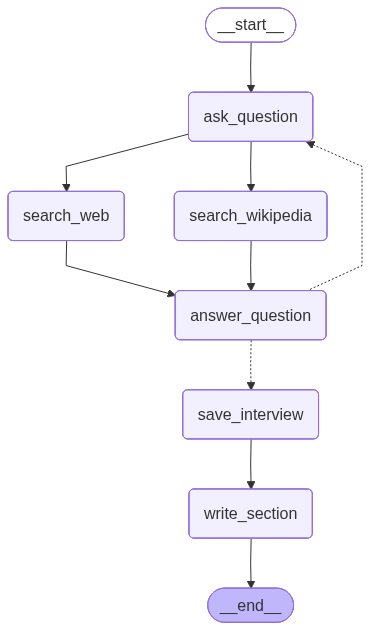

In [21]:
from langchain_core.messages import get_buffer_string

# Search query writing
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert. 

Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.
        
First, analyze the full conversation.

Pay particular attention to the final question posed by the analyst.

Convert this final question into a well-structured web search query""")

def search_web(state: InterviewState):
    
    """ Retrieve docs from web search """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    # Search
    search_docs = tavily_search.invoke(search_query.search_query)

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

def search_wikipedia(state: InterviewState):
    
    """ Retrieve docs from wikipedia """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    # Search
    search_docs = WikipediaLoader(query=search_query.search_query, 
                                  load_max_docs=2).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""

def generate_answer(state: InterviewState):
    
    """ Node to answer a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # Answer question
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)
            
    # Name the message as coming from the expert
    answer.name = "expert"
    
    # Append it to state
    return {"messages": [answer]}

def save_interview(state: InterviewState):
    
    """ Save interviews """

    # Get messages
    messages = state["messages"]
    
    # Convert interview to a string
    interview = get_buffer_string(messages)
    
    # Save to interviews key
    return {"interview": interview}

def route_messages(state: InterviewState, 
                   name: str = "expert"):

    """ Route between question and answer """
    
    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    return "ask_question"

section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

def write_section(state: InterviewState):

    """ Node to answer a question """

    # Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]
   
    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")]) 
                
    # Append it to state
    return {"sections": [section.content]}

# Add nodes and edges 
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

# Flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("ask_question", "search_wikipedia")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_edge("search_wikipedia", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages,['ask_question','save_interview'])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

# Interview 
memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")

# View
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [22]:
# Pick one analyst
analysts[0]

Analyst(affiliation='Tech Innovators Inc.', name='Alex Johnson', role='Startup Entrepreneur', description="Alex is a co-founder of a tech startup that focuses on developing AI-driven solutions for small businesses. With a keen interest in leveraging cutting-edge technologies to gain competitive advantages, Alex is particularly interested in how LangGraph can streamline development processes, reduce costs, and enhance product scalability. Alex's perspective is driven by the need for efficient, cost-effective solutions that can be rapidly deployed to meet market demands.")

Here, we run the interview passing an index of the llama3.1 paper, which is related to our topic.

In [23]:
from IPython.display import Markdown
messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]
thread = {"configurable": {"thread_id": "1"}}
interview = interview_graph.invoke({"analyst": analysts[0], "messages": messages, "max_num_turns": 2}, thread)
Markdown(interview['sections'][0])

## LangGraph: Revolutionizing AI-Driven Solutions for Small Businesses

### Summary

In the rapidly evolving landscape of AI-driven solutions, LangGraph emerges as a pivotal framework for small businesses aiming to leverage cutting-edge technology to streamline development processes, reduce costs, and enhance product scalability. As a co-founder of a tech startup, Alex is particularly interested in how LangGraph can be utilized to gain competitive advantages in the market. The framework's ability to coordinate multiple AI agents in a structured and scalable manner presents novel opportunities for businesses to optimize their operations and improve customer engagement.

LangGraph's architecture allows for precise control over AI agent interactions, enabling workflows where agents can operate in parallel or await specific inputs, much like a human team [1]. This approach not only mirrors human collaboration but also introduces efficiencies such as specialization and oversight, which are crucial for reducing errors and saving time and money [1]. The framework's design supports the creation of complex, stateful applications that can be rapidly deployed, making it an ideal choice for startups looking to scale their operations without incurring significant overhead [2].

One of the most surprising insights is LangGraph's ability to enhance communication between AI systems and users through its natural language processing capabilities. This leads to improved customer satisfaction and engagement, as AI agents can better understand and respond to user queries [2]. Additionally, LangGraph's data representation allows AI agents to make informed decisions, optimizing operations and reducing costs [2]. The framework's flexibility in adding new AI agents ensures that businesses can swiftly adapt to changing market demands, a critical factor for startups aiming to maintain a competitive edge [2].

LangGraph's practical applications are already being demonstrated by companies like Uber and Klarna, which use the framework to manage critical AI workflows and improve customer support systems [3]. The ability to build AI-driven chatbots and support systems that handle complex multi-turn conversations further underscores LangGraph's potential to transform customer interactions and streamline business processes [4].

In conclusion, LangGraph offers a robust solution for small businesses seeking to harness the power of AI. Its ability to coordinate multiple agents, enhance communication, and provide scalable solutions makes it an invaluable tool for startups looking to innovate and grow in a competitive market.

### Sources
[1] https://www.scalablepath.com/machine-learning/langgraph  
[2] https://www.rapidinnovation.io/post/ai-agents-in-langgraph  
[3] https://duplocloud.com/blog/langchain-vs-langgraph  
[4] https://www.projectpro.io/article/langgraph-projects-and-examples/1124  

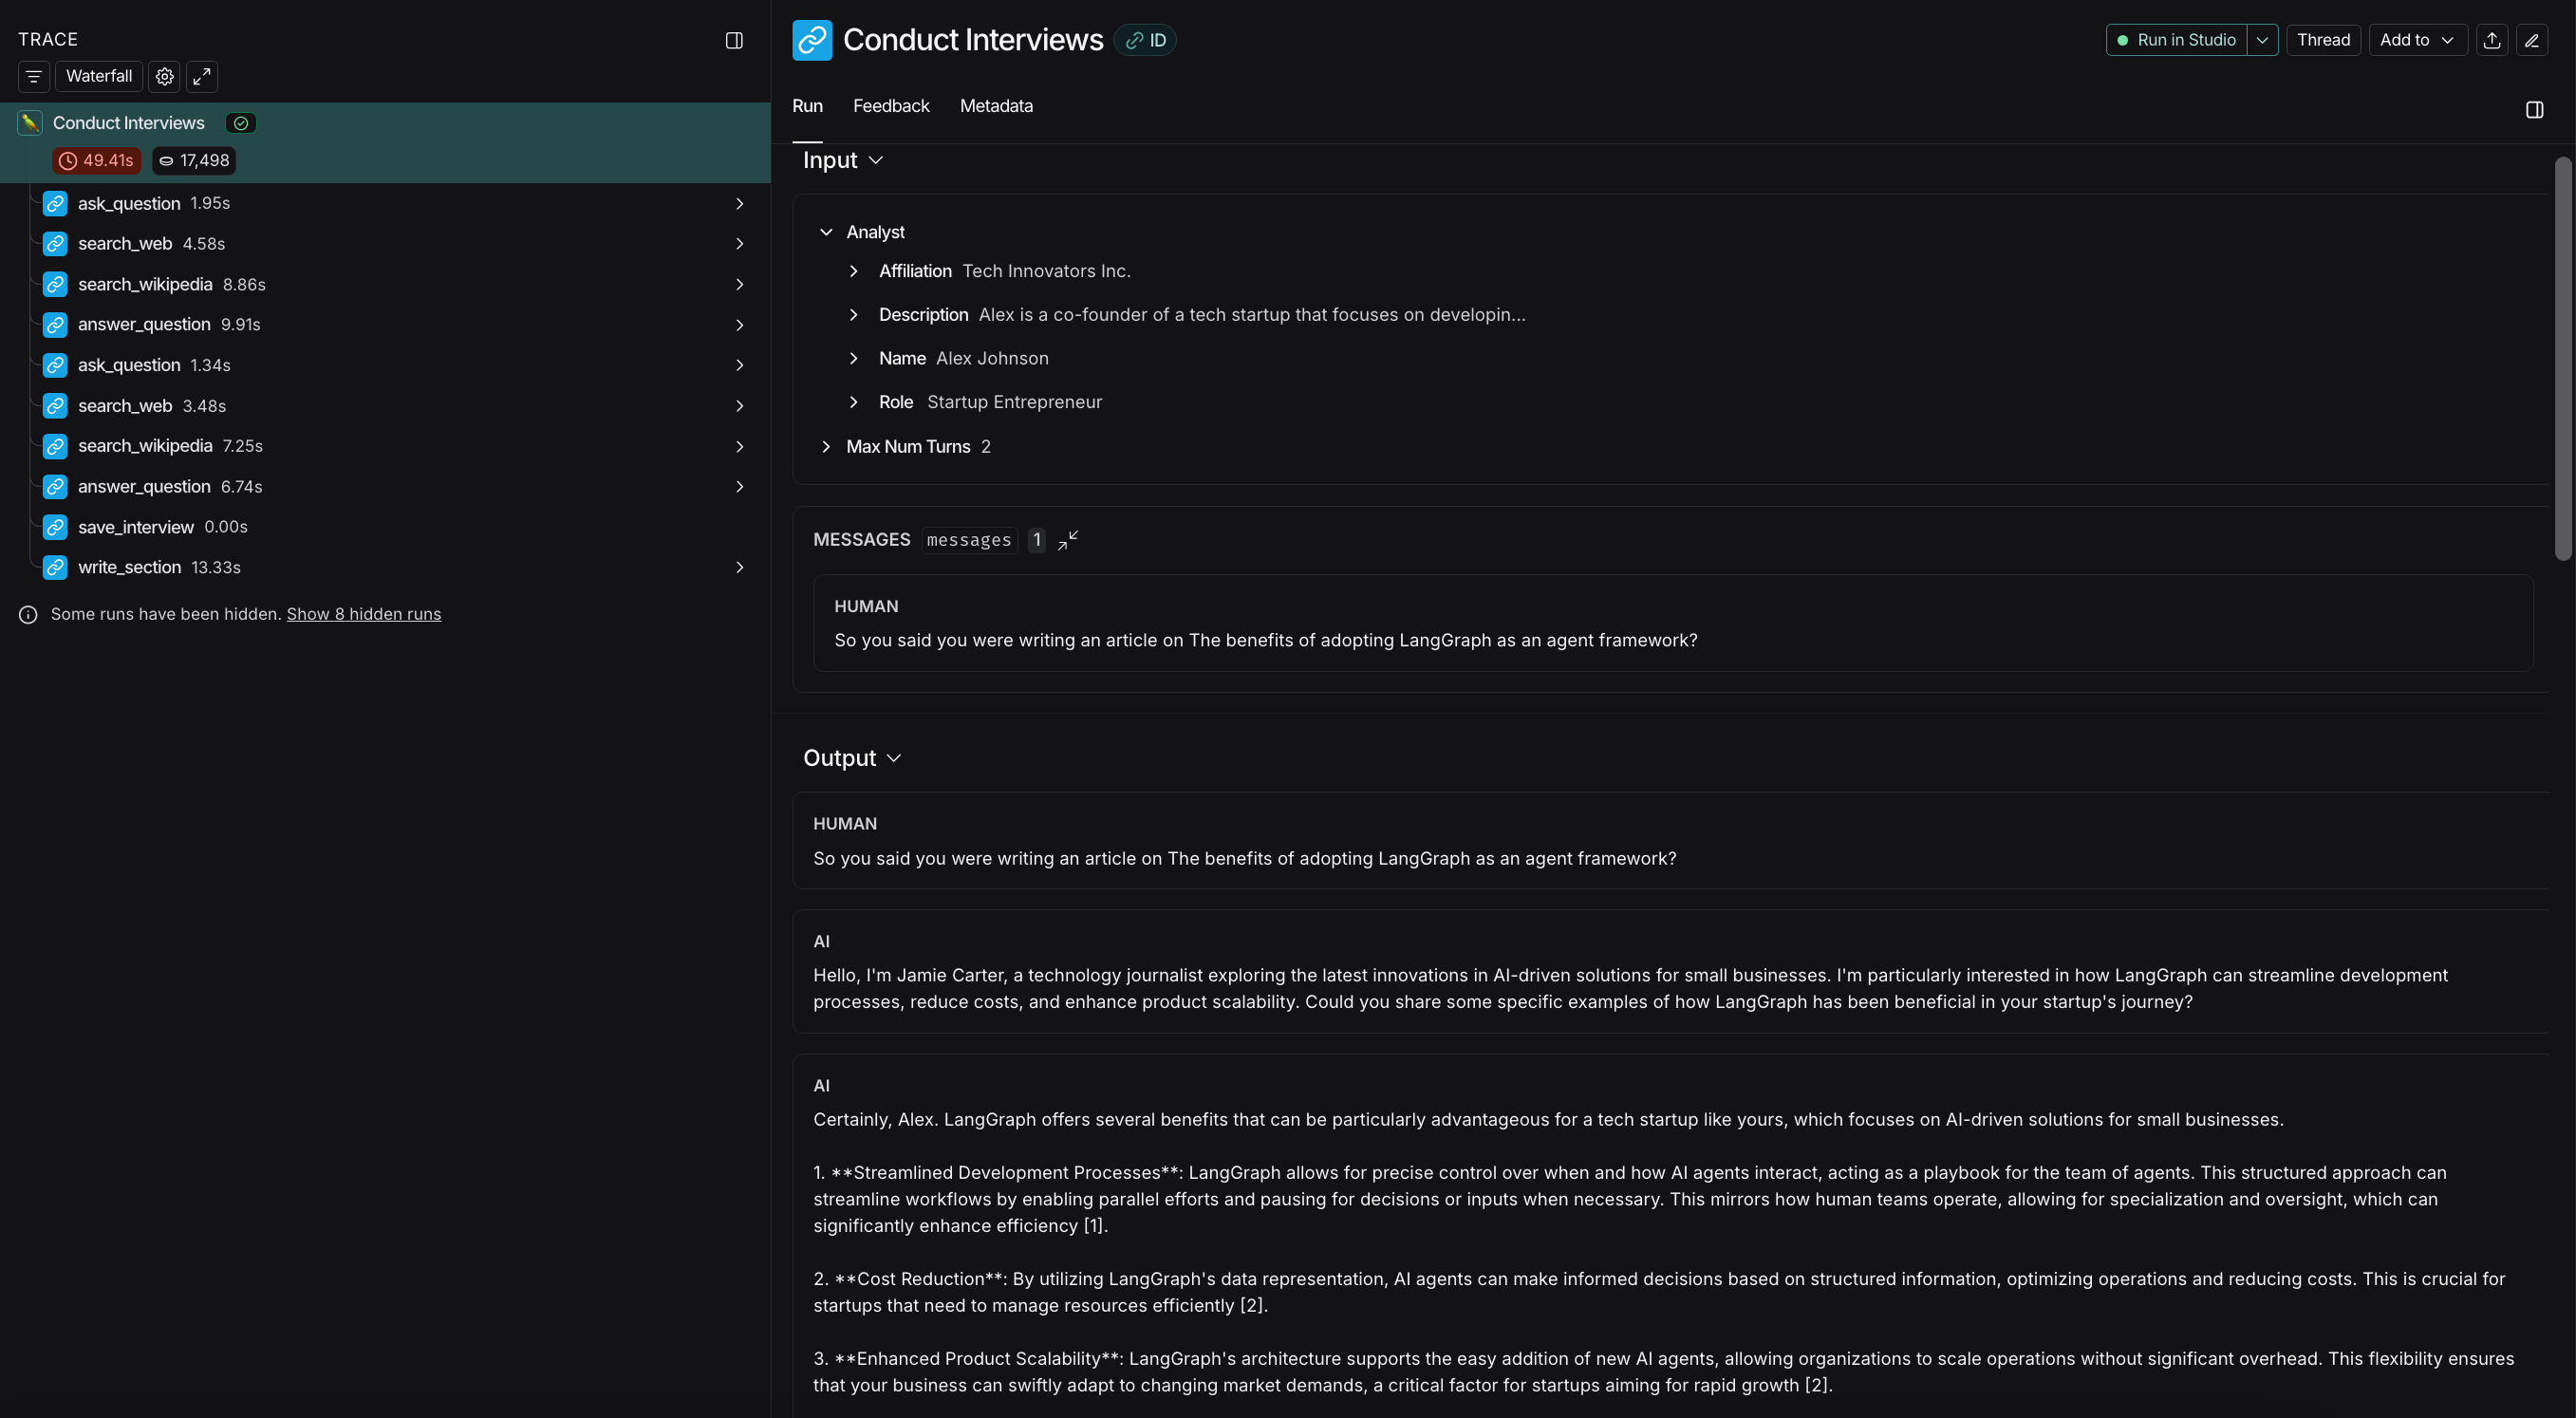

### Parallelze interviews: Map-Reduce

We parallelize the interviews via the `Send()` API, a map step.

We combine them into the report body in a reduce step.

### Finalize

We add a final step to write an intro and conclusion to the final report.

In [24]:
import operator
from typing import List, Annotated
from typing_extensions import TypedDict

class ResearchGraphState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    sections: Annotated[list, operator.add] # Send() API key
    introduction: str # Introduction for the final report
    content: str # Content for the final report
    conclusion: str # Conclusion for the final report
    final_report: str # Final report

/var/folders/8r/dlpk1dt126d92cp3025l_mfw0000gn/T/ipykernel_97541/1161942424.py:1: LangGraphDeprecatedSinceV10: Importing Send from langgraph.constants is deprecated. Please use 'from langgraph.types import Send' instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  from langgraph.constants import Send


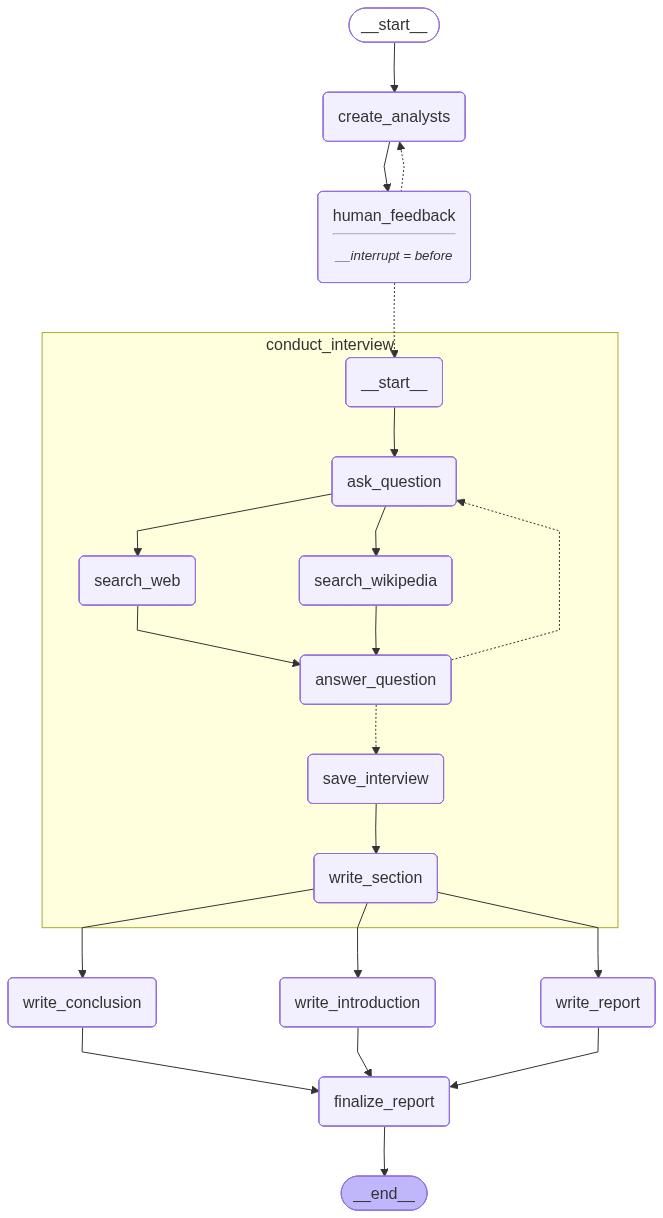

In [25]:
from langgraph.constants import Send

def initiate_all_interviews(state: ResearchGraphState):
    """ This is the "map" step where we run each interview sub-graph using Send API """    

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback')
    if human_analyst_feedback:
        # Return to create_analysts
        return "create_analysts"

    # Otherwise kick off interviews in parallel via Send() API
    else:
        topic = state["topic"]
        return [Send("conduct_interview", {"analyst": analyst,
                                           "messages": [HumanMessage(
                                               content=f"So you said you were writing an article on {topic}?"
                                           )
                                                       ]}) for analyst in state["analysts"]]

report_writer_instructions = """You are a technical writer creating a report on this overall topic: 

{topic}
    
You have a team of analysts. Each analyst has done two things: 

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task: 

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos. 
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:
 
1. Use markdown formatting. 
2. Include no pre-amble for the report.
3. Use no sub-heading. 
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from: 

{context}"""

def write_report(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)    
    report = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based upon these memos.")]) 
    return {"content": report.content}

intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting. 

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header. 

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""

def write_introduction(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    intro = llm.invoke([instructions]+[HumanMessage(content=f"Write the report introduction")]) 
    return {"introduction": intro.content}

def write_conclusion(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    conclusion = llm.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")]) 
    return {"conclusion": conclusion.content}

def finalize_report(state: ResearchGraphState):
    """ The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    # Save full final report
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}

# Add nodes and edges 
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report",write_report)
builder.add_node("write_introduction",write_introduction)
builder.add_node("write_conclusion",write_conclusion)
builder.add_node("finalize_report",finalize_report)

# Logic
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

Let's ask an open-ended question about LangGraph.

In [26]:
# Inputs
max_analysts = 3 
topic = "The benefits of adopting LangGraph as an agent framework"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,
                           "max_analysts":max_analysts}, 
                          thread, 
                          stream_mode="values"):
    
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Carter
Affiliation: Tech Innovators Inc.
Role: AI Framework Specialist
Description: Dr. Carter focuses on the technical advantages of adopting LangGraph as an agent framework. Her primary interest lies in how LangGraph enhances the efficiency and scalability of AI systems. She is particularly concerned with the framework's ability to integrate seamlessly with existing technologies and its potential to reduce development time and costs.
--------------------------------------------------
Name: Mr. Raj Patel
Affiliation: Global AI Ethics Consortium
Role: Ethical AI Advocate
Description: Mr. Patel is dedicated to exploring the ethical implications of adopting new AI frameworks like LangGraph. He is interested in how LangGraph can promote transparency and accountability in AI systems. His concerns include ensuring that the framework supports ethical AI practices and does not inadvertently introduce biases or privacy issues.
--------------------------------------------------


In [27]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback": 
                                "Add in the CEO of gen ai native startup"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b61d8-9a87-6970-8002-0de3eeb400d6'}}

In [28]:
# Check
for event in graph.stream(None, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Carter
Affiliation: Tech Innovators Inc.
Role: AI Framework Specialist
Description: Dr. Carter focuses on the technical advantages of adopting LangGraph as an agent framework. Her primary interest lies in how LangGraph enhances the efficiency and scalability of AI systems. She is particularly concerned with the framework's ability to integrate seamlessly with existing technologies and its potential to reduce development time and costs.
--------------------------------------------------
Name: Mr. Raj Patel
Affiliation: Global AI Ethics Consortium
Role: Ethical AI Advocate
Description: Mr. Patel is dedicated to exploring the ethical implications of adopting new AI frameworks like LangGraph. He is interested in how LangGraph can promote transparency and accountability in AI systems. His concerns include ensuring that the framework supports ethical AI practices and does not inadvertently introduce biases or privacy issues.
--------------------------------------------------


In [29]:
# Confirm we are happy
graph.update_state(thread, {"human_analyst_feedback": 
                            None}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b61d9-1ff3-6942-8004-6e0df680b7b1'}}

In [30]:
# Continue
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

--Node--
conduct_interview
--Node--
conduct_interview
--Node--
conduct_interview
--Node--
write_introduction
--Node--
write_conclusion
--Node--
write_report
--Node--
finalize_report


In [31]:
from IPython.display import Markdown
final_state = graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)

# The Benefits of Adopting LangGraph as an Agent Framework

## Introduction

In the dynamic realm of artificial intelligence, LangGraph emerges as a transformative agent framework, offering substantial technical, environmental, and strategic advantages. This report explores how LangGraph enhances AI systems' efficiency and scalability through seamless integration and robust state management. It delves into the framework's environmental benefits, showcasing its potential to reduce energy consumption and improve AI operations' carbon footprint. Additionally, the report highlights LangGraph's strategic value for AI startups, emphasizing its role in accelerating time-to-market and fostering innovation. By adopting LangGraph, organizations can unlock AI's full potential while promoting sustainability and gaining a competitive edge.

---



LangGraph emerges as a transformative agent framework in the realm of artificial intelligence, offering a multitude of benefits that enhance efficiency, scalability, and sustainability across various sectors. Its integration capabilities, technical advantages, and strategic benefits make it a compelling choice for enterprises and startups alike.

Technically, LangGraph provides significant advantages by seamlessly integrating with existing technologies, such as Amazon Bedrock, to develop sophisticated multi-agent systems. This integration leverages LangGraph’s orchestration capabilities, addressing challenges in multi-agent architectures through state management, agent coordination, and workflow orchestration. Features like memory management and error handling ensure reliable automation, even in high-pressure environments [1][2]. The framework's scalable and modular design allows multiple agents to work together within a single workflow, facilitating task assignment, state sharing, and decision coordination. This design is particularly beneficial for cross-functional support flows and customer handoffs [2][3]. LangGraph's visual and modular orchestration capabilities provide precise control over agent interactions, boosting efficiency and reducing errors [4].

From an environmental perspective, LangGraph contributes to sustainable AI practices by reducing energy consumption and improving the carbon footprint of AI operations. Its integration with AutoGen has demonstrated significant improvements in operational efficiency, such as in intelligent traffic systems where it accelerated vehicle movement and reduced driving times, leading to lower energy usage [1]. LangGraph's natural language processing capabilities enhance communication and decision-making, resulting in optimized operations and reduced costs [3]. This structured approach to data representation enables AI agents to make informed decisions, further promoting sustainability [3].

For AI startups, LangGraph offers strategic advantages by reducing time-to-market and enhancing product innovation. Its modular architecture supports rapid prototyping and deployment, enabling a 40% faster time-to-market compared to other frameworks [2]. The ability to create cyclical graphs and manage sophisticated language tasks allows startups to build adaptable and customizable agent runtimes, enhancing user engagement [3]. Additionally, LangGraph's robust error handling and debugging tools contribute to a reduction in software maintenance costs, providing a cost-effective solution for startups [2]. The platform's dual-mode streaming capability ensures a responsive user experience, essential for real-time applications [4].

In summary, LangGraph stands out as a powerful tool for enhancing AI systems' efficiency, scalability, and sustainability. Its seamless integration capabilities, robust state management, and modular design make it a strategic asset for organizations looking to leverage AI technologies effectively, while also promoting greener AI practices and offering strategic advantages for startups.


---

## Conclusion

LangGraph emerges as a transformative agent framework, offering substantial benefits across various domains. Its integration with platforms like Amazon Bedrock enhances AI system efficiency and scalability, addressing challenges in multi-agent architectures through robust state management and workflow orchestration. The framework's environmental benefits are equally compelling, as it reduces energy consumption and improves AI operations' carbon footprint, promoting sustainable practices. For AI startups, LangGraph provides a strategic advantage by accelerating time-to-market and reducing maintenance costs, fostering innovation and business growth. Overall, LangGraph stands out as a powerful tool for enterprises and startups alike, driving efficiency, sustainability, and competitive edge in AI development.

## Sources
[1] https://aws.amazon.com/blogs/machine-learning/build-multi-agent-systems-with-langgraph-and-amazon-bedrock/  
[2] https://www.ema.co/additional-blogs/addition-blogs/building-ai-agents-langgraph/  
[3] https://www.rapidinnovation.io/post/how-to-integrate-langgraph-with-autogen-crewai-and-other-frameworks  
[4] https://www.scalablepath.com/machine-learning/langgraph/  
[5] https://wjaets.com/sites/default/files/WJAETS-2023-0068.pdf  
[6] https://www.rapidinnovation.io/post/top-3-trending-agentic-ai-frameworks-langgraph-vs-autogen-vs-crew-ai  
[7] https://www.rapidinnovation.io/post/ai-agents-in-langgraph  
[8] https://lekha-bhan88.medium.com/5-reasons-why-langgraph-is-a-breakthrough-for-building-stateful-controllable-ai-agents-8f8de4afcbf8  
[9] https://sparkco.ai/blog/langgraph-vs-crewai-vs-autogen-2025-production-showdown  
[10] https://www.linkedin.com/pulse/what-langgraph-how-useful-building-llm-based-sarfraz-nawaz-walic  
[11] https://www.firecrawl.dev/blog/langgraph-startup-validator-tutorial

We can look at the trace:

https://smith.langchain.com/public/2933a7bb-bcef-4d2d-9b85-cc735b22ca0c/r

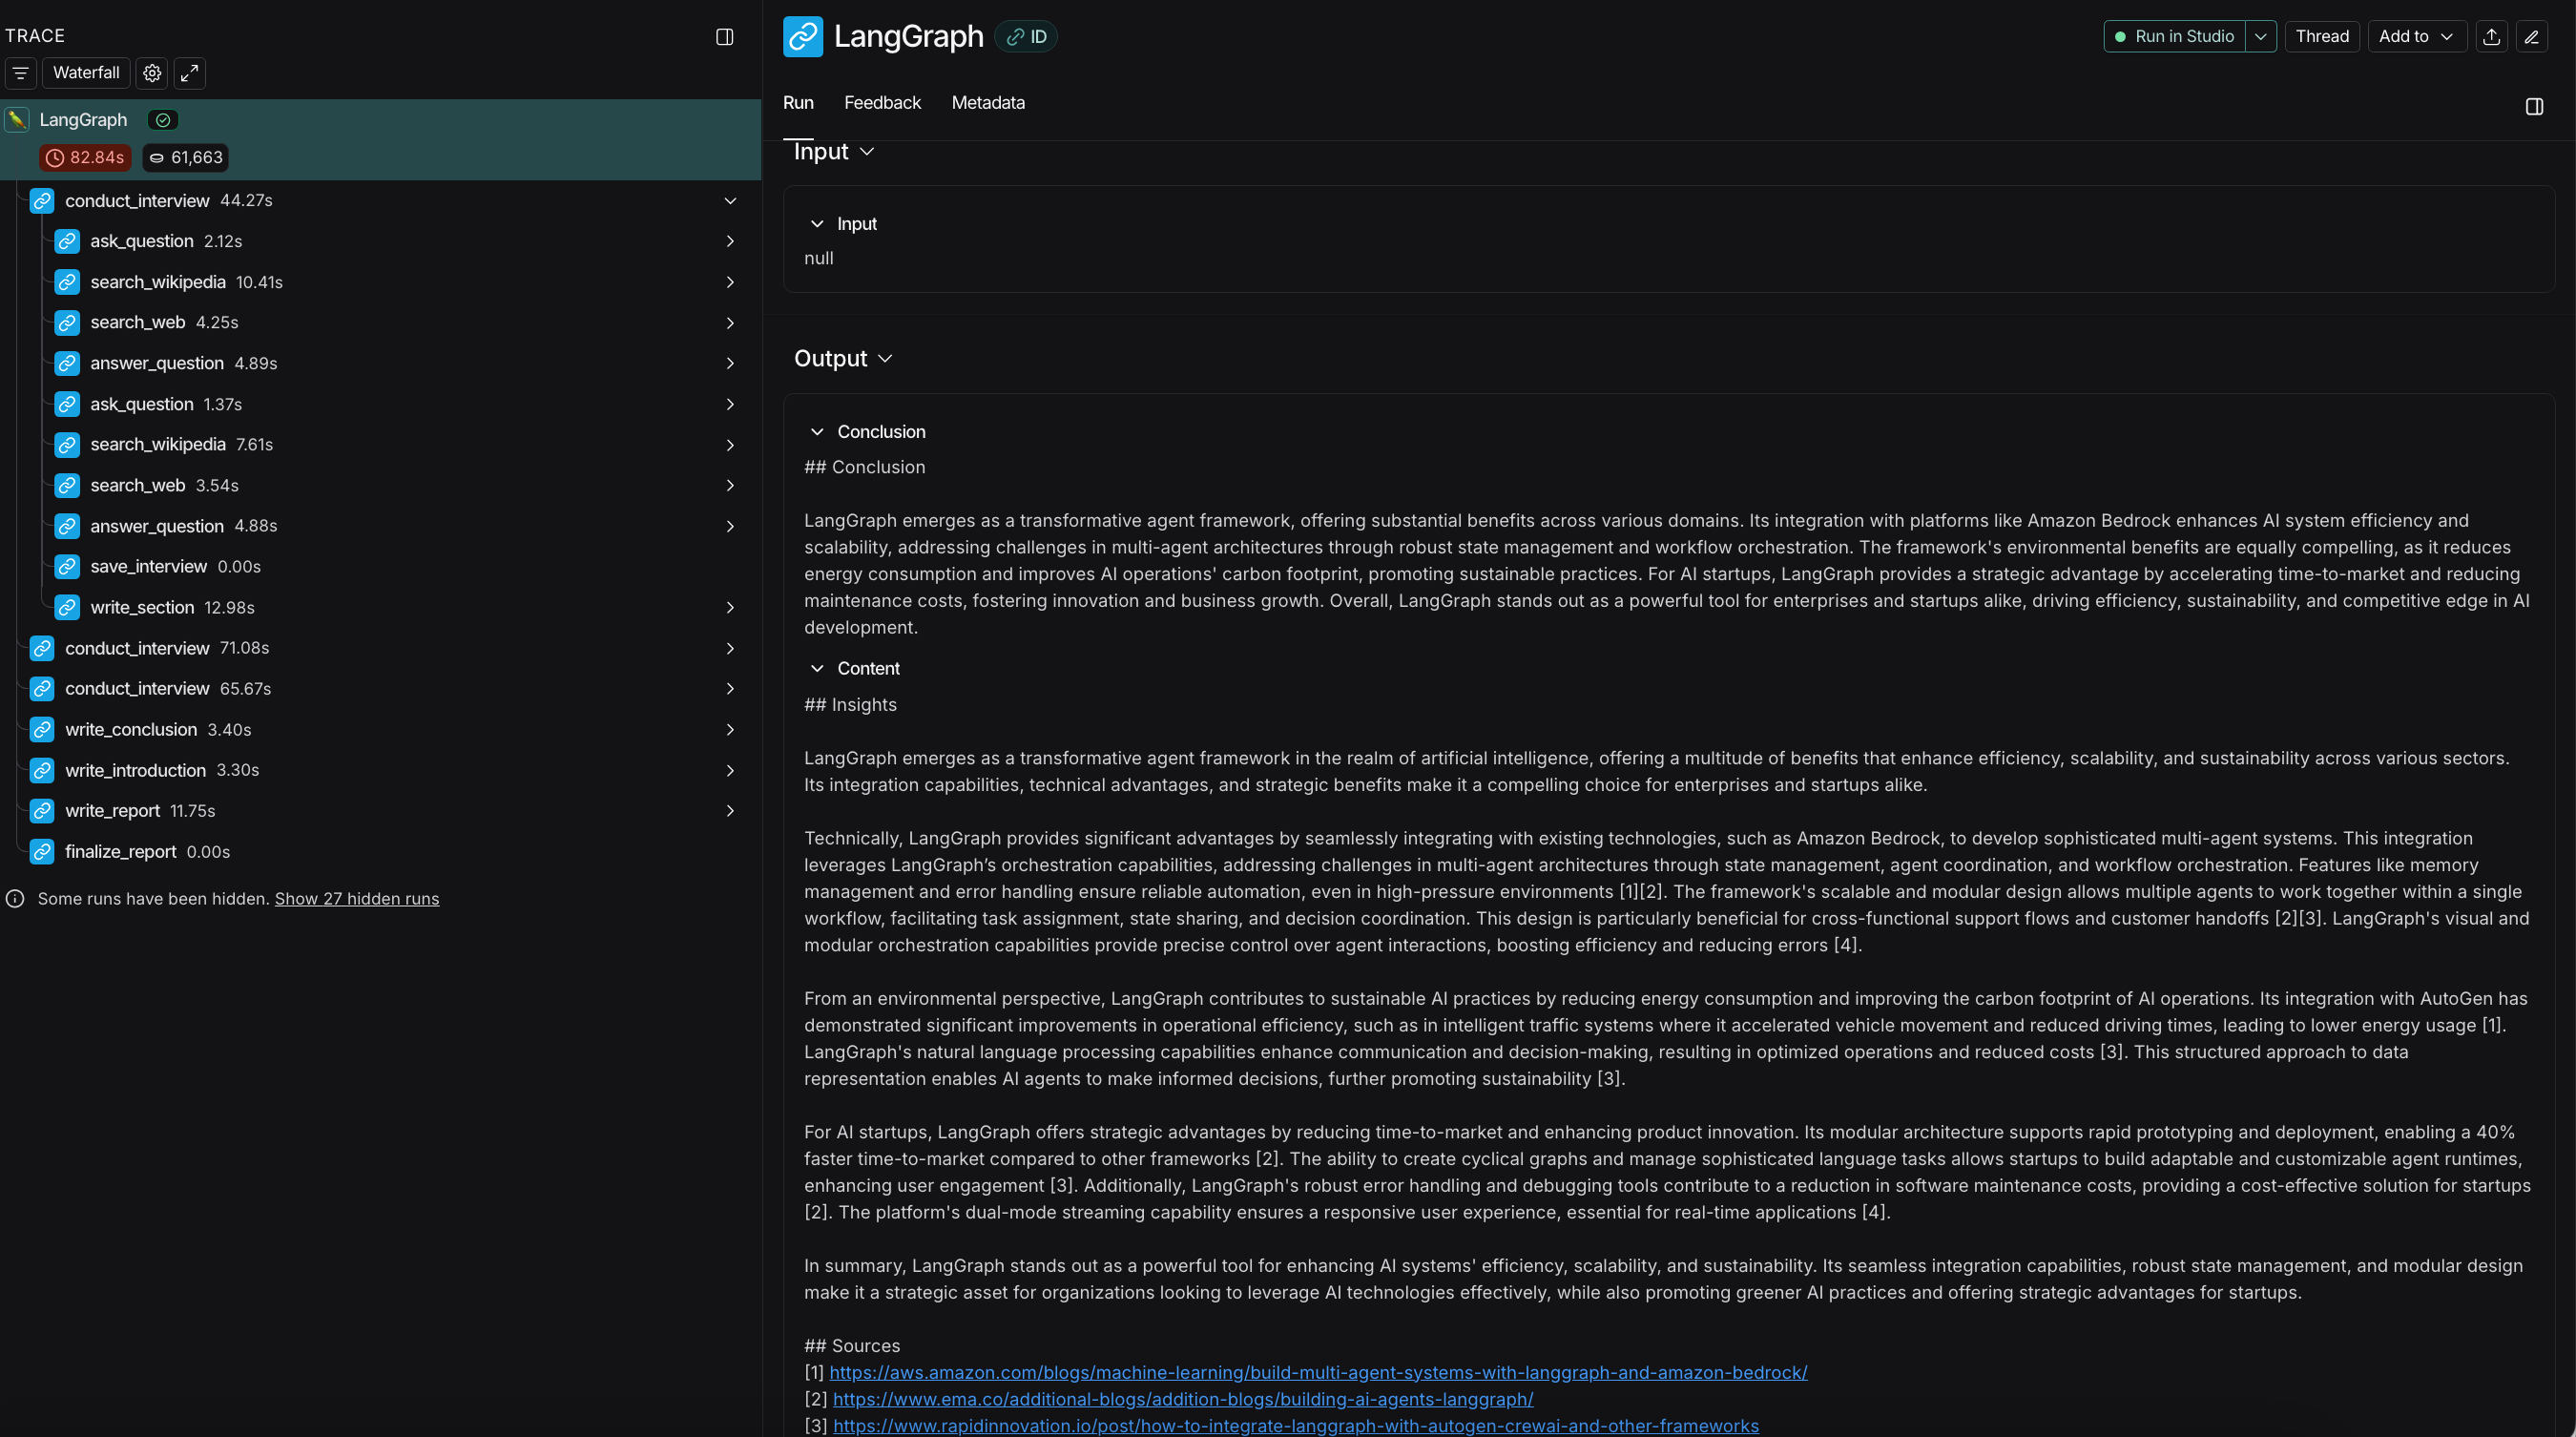
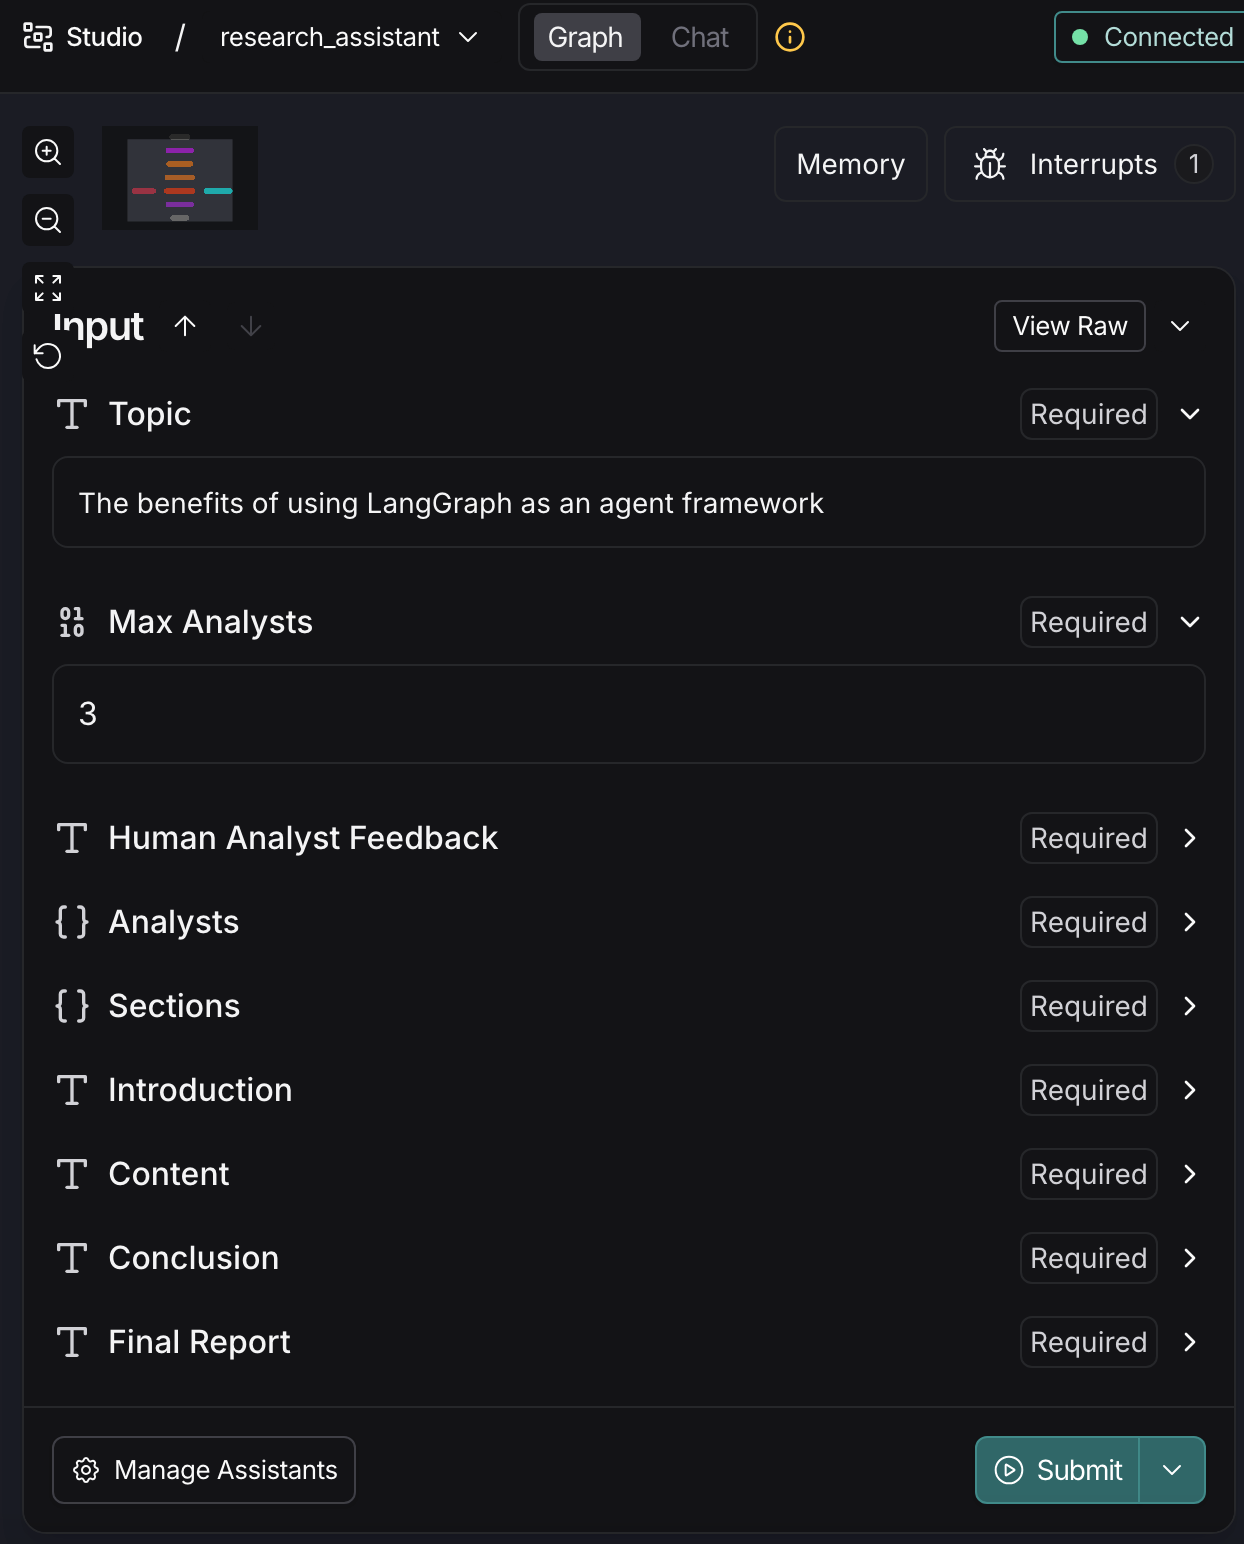
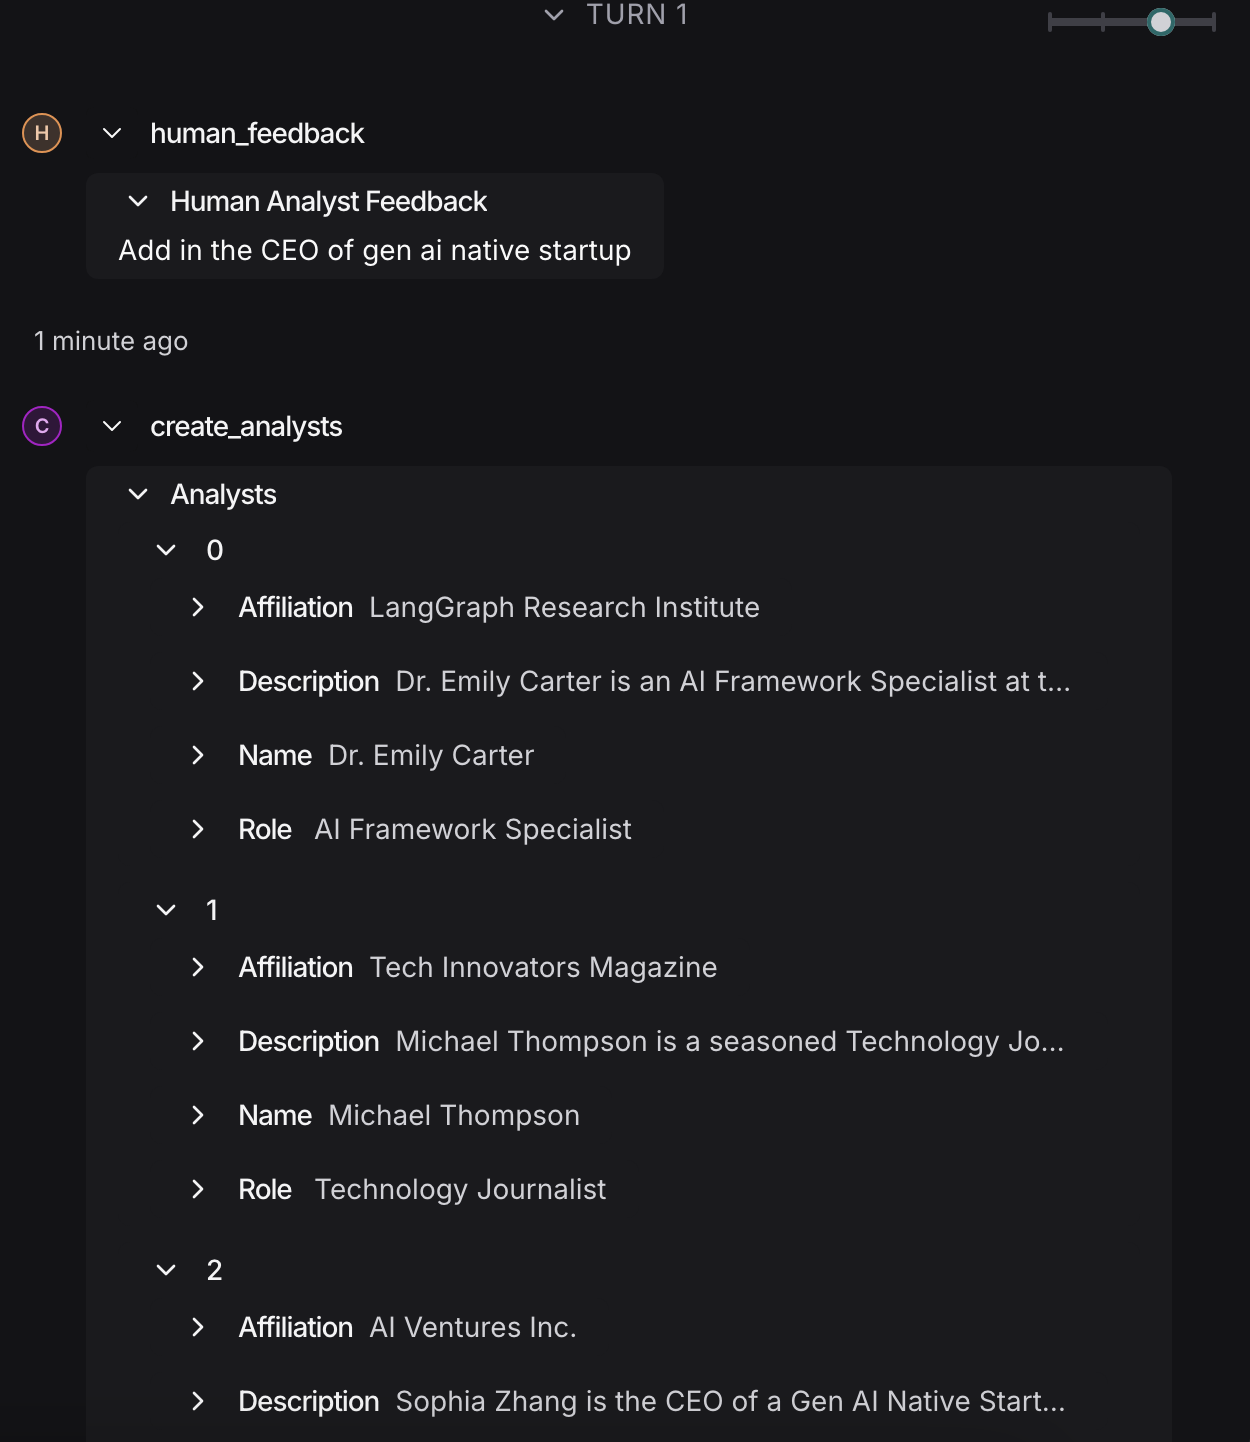
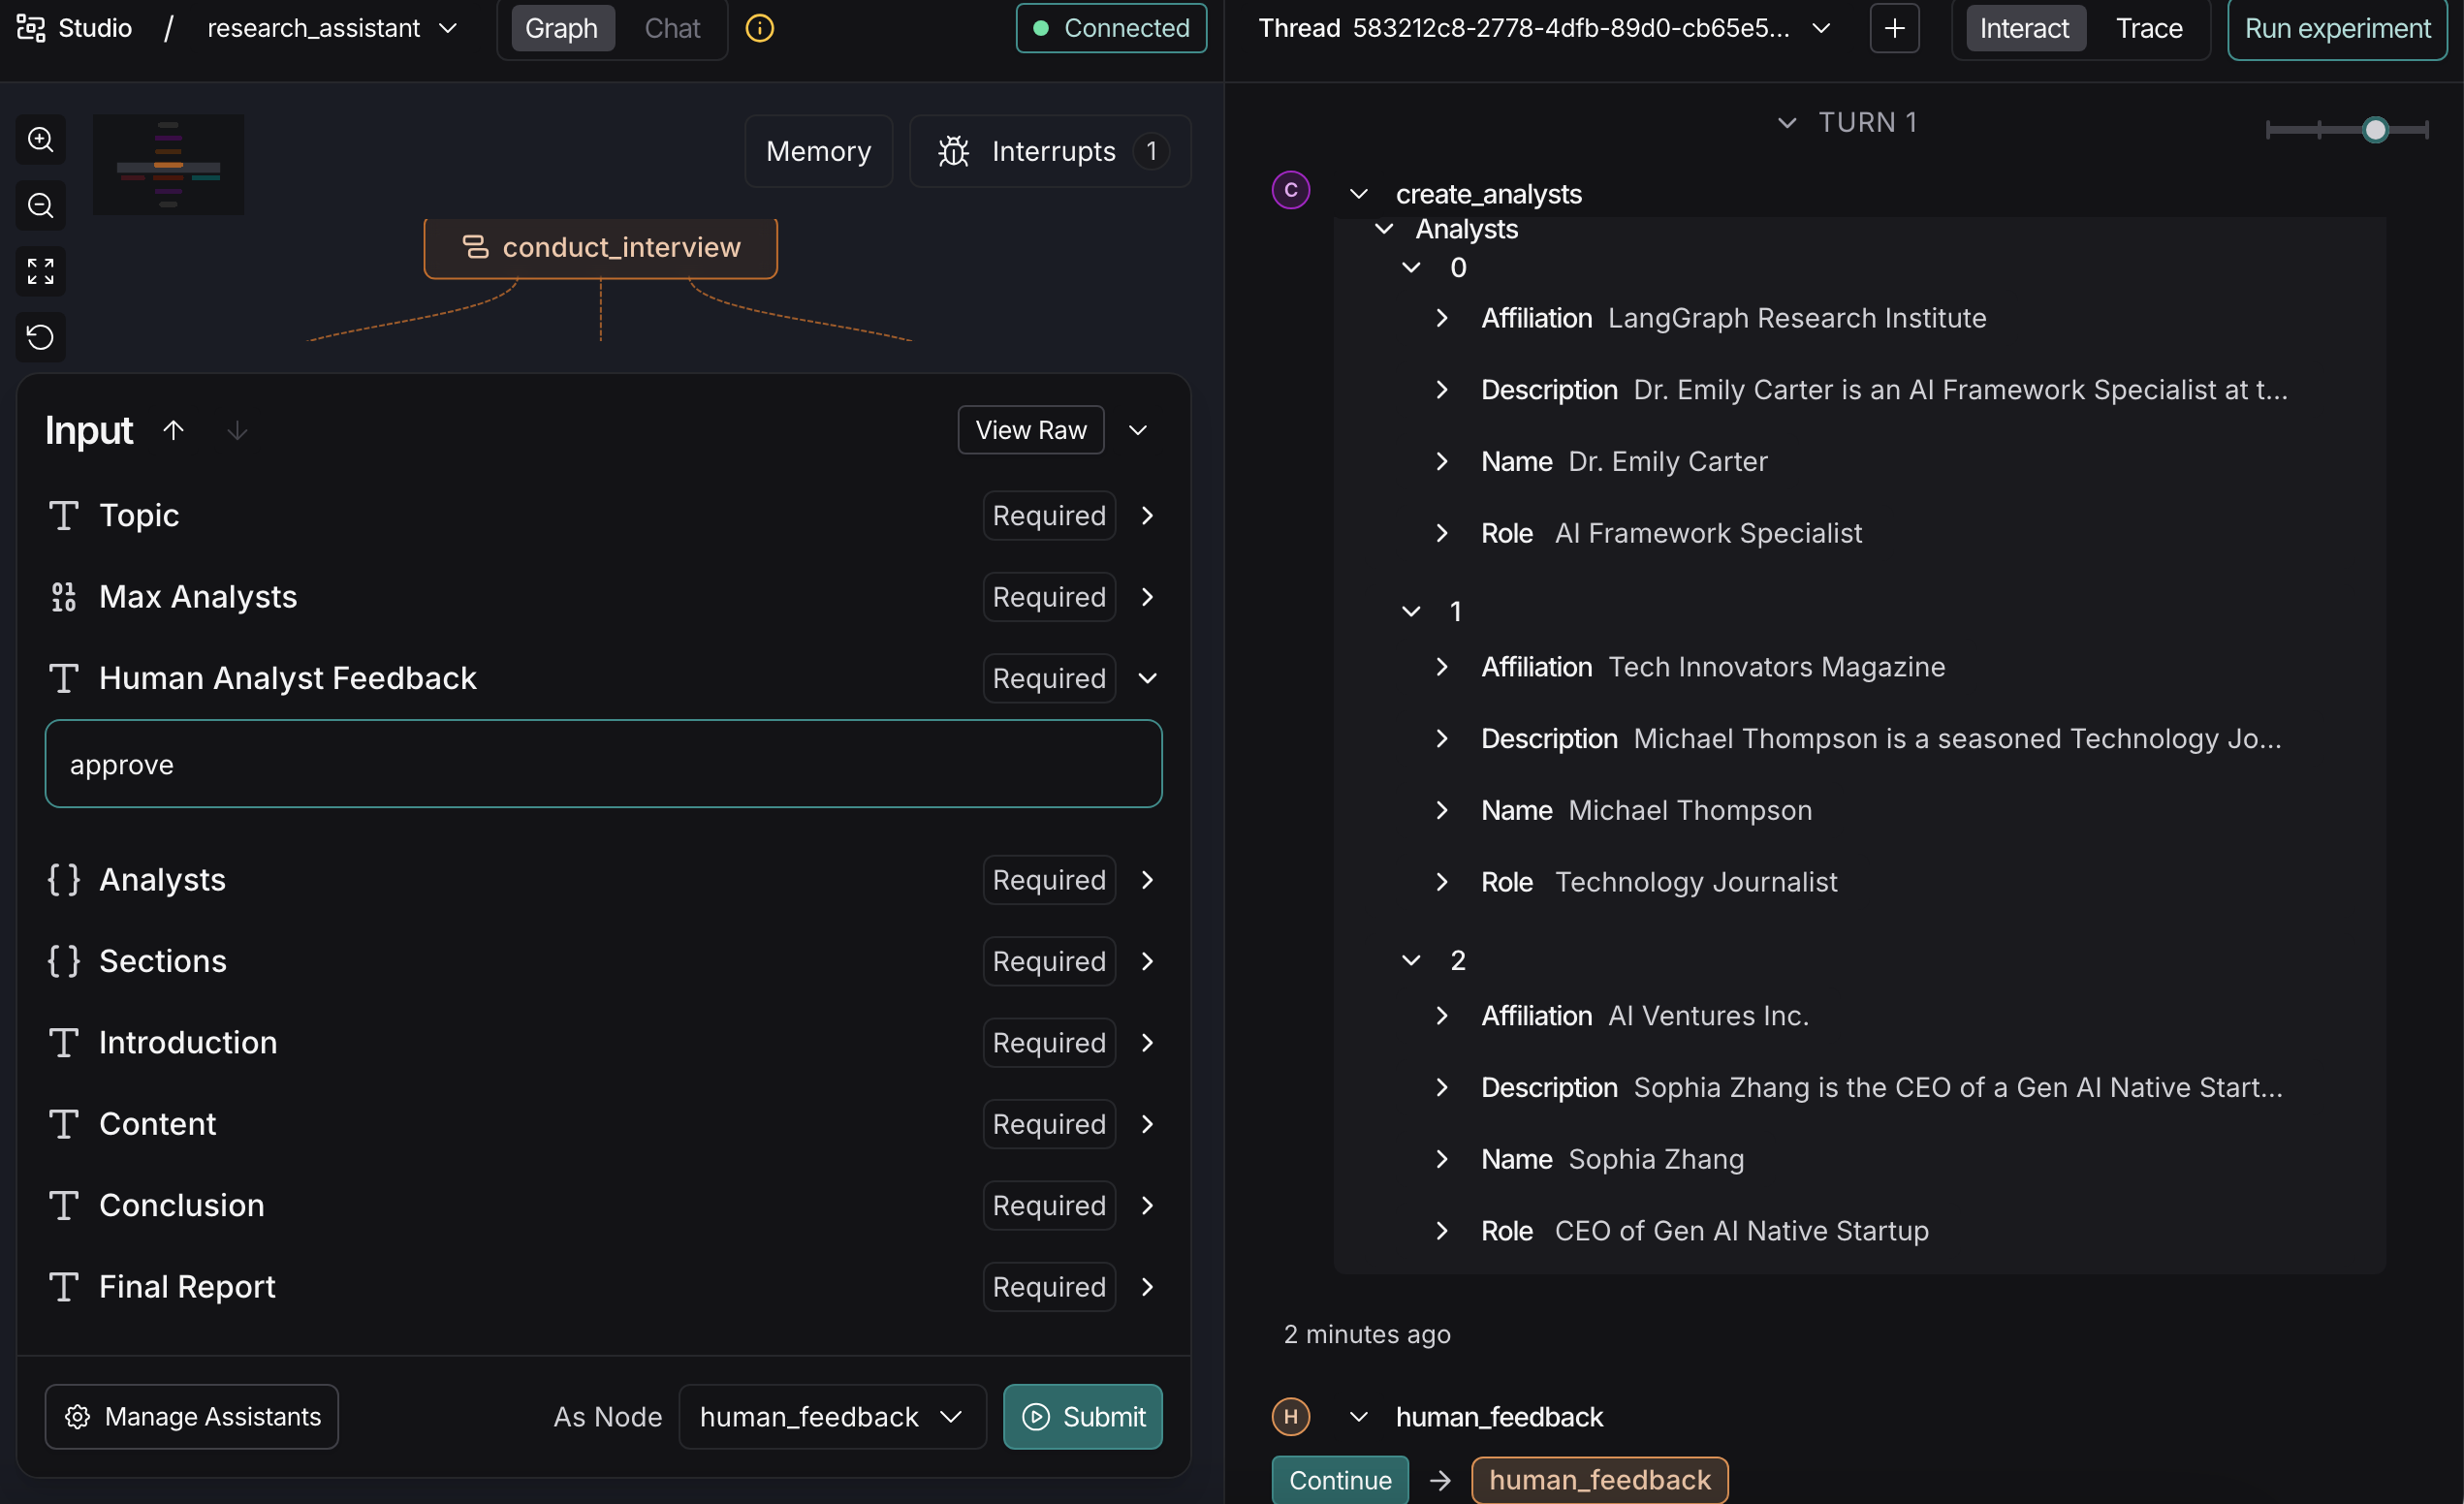
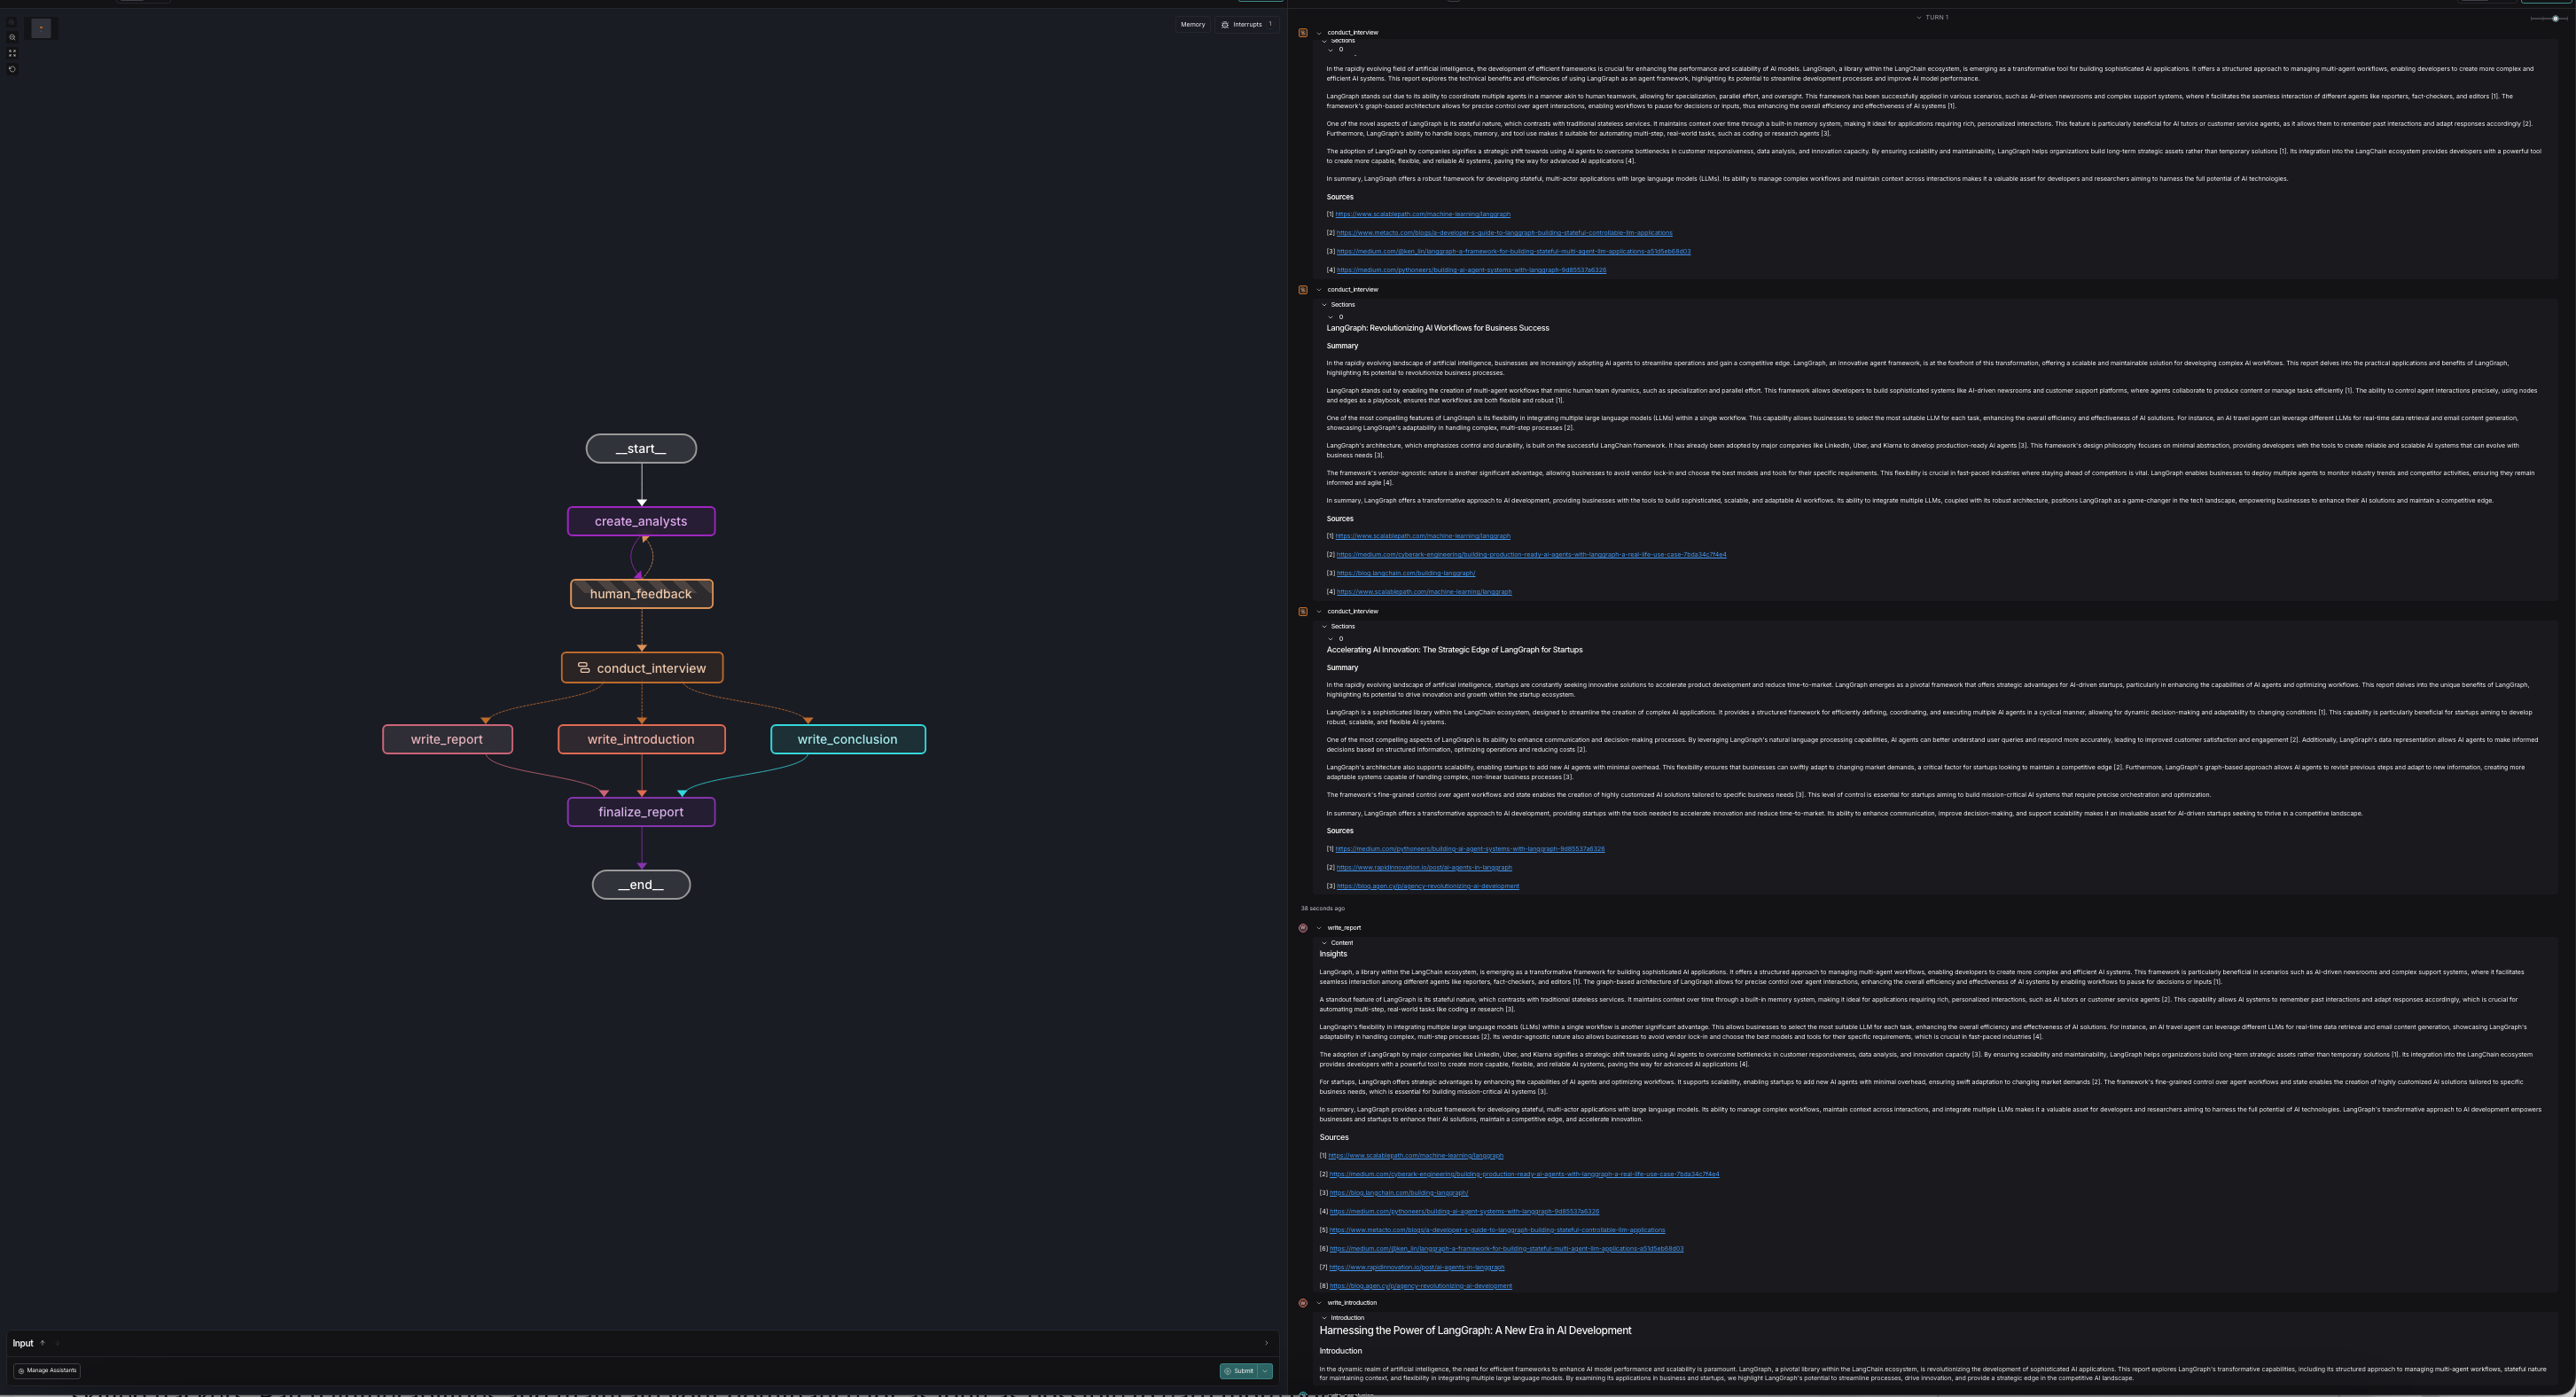

# SELF-EXERCISE:

#### Defined Specialist Personas

In [77]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

class CrisisSpecialist(BaseModel):
    name: str = Field(description="Name of the crisis response specialist.")
    role: str = Field(description="Their operational role during the crisis.")
    agency: str = Field(description="Which agency or organization they represent.")
    focus: str = Field(description="Their tactical or strategic focus during the emergency.")
    
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAgency: {self.agency}\nFocus: {self.focus}\n"

class ResponseTeam(BaseModel):
    specialists: List[CrisisSpecialist] = Field(description="List of crisis response specialists for the event.")

class GenerateSpecialistsState(TypedDict):
    event_name: str
    max_specialists: int
    director_feedback: str
    specialists: List[CrisisSpecialist]

#### Created Specialists (Map Phase)

In [78]:
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

specialist_instructions = """You are creating AI personas for an emergency response simulation.

1. Review the crisis event: {event_name}.
2. Review any director feedback: {director_feedback}.
3. Choose {max_specialists} critical domains (medical, logistics, communications, cybersecurity, infrastructure recovery, etc.).
4. For each domain, assign one specialist with a name, agency, role, and focus."""

def create_specialists(state: GenerateSpecialistsState):
    event_name = state["event_name"]
    max_specialists = state["max_specialists"]
    feedback = state.get("director_feedback", "")

    structured_llm = llm.with_structured_output(ResponseTeam)
    system_message = specialist_instructions.format(
        event_name=event_name, director_feedback=feedback, max_specialists=max_specialists
    )

    result = structured_llm.invoke(
        [SystemMessage(content=system_message), HumanMessage(content="Generate the crisis specialists.")]
    )

    return {"specialists": result.specialists}

def human_feedback(state: GenerateSpecialistsState):
    pass

def should_continue(state: GenerateSpecialistsState):
    if state.get("director_feedback"):
        return "create_specialists"
    return END

#### Specialist Graph (Generation + Human Feedback)

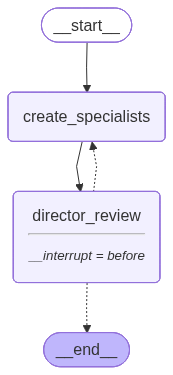

In [79]:
builder = StateGraph(GenerateSpecialistsState)
builder.add_node("create_specialists", create_specialists)
builder.add_node("director_review", human_feedback)
builder.add_edge(START, "create_specialists")
builder.add_edge("create_specialists", "director_review")
builder.add_conditional_edges("director_review", should_continue, ["create_specialists", END])

memory = MemorySaver()
specialist_graph = builder.compile(interrupt_before=["director_review"], checkpointer=memory)
display(Image(specialist_graph.get_graph(xray=1).draw_mermaid_png()))

#### Generated Specialists

In [80]:
event_name = "Earthquake in San Francisco, 2025"
max_specialists = 3
thread = {"configurable": {"thread_id": "1"}}

for event in specialist_graph.stream({"event_name": event_name, "max_specialists": max_specialists},
                                     thread, stream_mode="values"):
    specialists = event.get("specialists", "")
    if specialists:
        for s in specialists:
            print(s.persona)
            print("-" * 50)

Name: Dr. Emily Chen
Role: Lead Medical Officer
Agency: California Emergency Medical Services Authority
Focus: Coordinating medical response teams and managing field hospitals to provide immediate care to earthquake victims.

--------------------------------------------------
Name: Markus Jensen
Role: Logistics Coordinator
Agency: Federal Emergency Management Agency (FEMA)
Focus: Overseeing the distribution of essential supplies such as food, water, and shelter materials to affected areas.

--------------------------------------------------
Name: Sophia Ramirez
Role: Communications Director
Agency: San Francisco Department of Emergency Management
Focus: Ensuring effective communication between emergency services and the public, including managing public information and alerts.

--------------------------------------------------


#### Added Director Feedback

In [81]:
specialist_graph.update_state(
    thread,
    {"director_feedback": "Add a cybersecurity officer to protect communication networks from attacks."},
    as_node="director_review"
)

for event in specialist_graph.stream(None, thread, stream_mode="values"):
    specialists = event.get("specialists", "")
    if specialists:
        for s in specialists:
            print(s.persona)
            print("-" * 50)

Name: Dr. Emily Chen
Role: Lead Medical Officer
Agency: California Emergency Medical Services Authority
Focus: Coordinating medical response teams and managing field hospitals to provide immediate care to earthquake victims.

--------------------------------------------------
Name: Markus Jensen
Role: Logistics Coordinator
Agency: Federal Emergency Management Agency (FEMA)
Focus: Overseeing the distribution of essential supplies such as food, water, and shelter materials to affected areas.

--------------------------------------------------
Name: Sophia Ramirez
Role: Communications Director
Agency: San Francisco Department of Emergency Management
Focus: Ensuring effective communication between emergency services and the public, including managing public information and alerts.

--------------------------------------------------
Name: Dr. Emily Chen
Role: Lead Medical Officer
Agency: San Francisco Department of Public Health
Focus: Coordinating medical response teams and managing field 

#### Crisis Simulation Sub-Graph

In [82]:
import operator
from typing import Annotated
from langgraph.graph import MessagesState
from langchain_core.messages import get_buffer_string
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.document_loaders import WikipediaLoader

tavily_search = TavilySearchResults(max_results=3)

class CrisisSimState(MessagesState):
    max_num_turns: int
    context: Annotated[list, operator.add]
    specialist: CrisisSpecialist
    simulation_log: str
    crisis_memos: list

#### Generated Questions

In [83]:
question_instructions = """You are a Crisis Specialist preparing for an earthquake response.

Your focus:
{persona}

Begin by introducing yourself and ask the Crisis Simulation AI your first question about your focus area.
Continue for a few turns to gather actionable insights."""

def generate_question(state: CrisisSimState):
    spec = state["specialist"]
    messages = state["messages"]
    sys_msg = question_instructions.format(persona=spec.persona)
    question = llm.invoke([SystemMessage(content=sys_msg)] + messages)
    return {"messages": [question]}

#### Search Web / Wikipedia for Data

In [84]:
from langchain_core.messages import SystemMessage

search_instructions = SystemMessage(
    content="""Given a conversation between a crisis specialist and a simulator AI,
produce a concise search query for real-world or historical data relevant to the conversation."""
)

class SearchQuery(BaseModel):
    search_query: str

def search_web(state: CrisisSimState):
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions] + state["messages"])
    docs = tavily_search.invoke(search_query.search_query)
    formatted = "\n\n---\n\n".join([f'<Document href="{d["url"]}"/>\n{d["content"]}' for d in docs])
    return {"context": [formatted]}

def search_wikipedia(state: CrisisSimState):
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions] + state["messages"])
    docs = WikipediaLoader(query=search_query.search_query, load_max_docs=2).load()
    formatted = "\n\n---\n\n".join([f'<Document source="{d.metadata["source"]}"/>\n{d.page_content}' for d in docs])
    return {"context": [formatted]}

#### Generated Answers + Save Logs

In [85]:
answer_instructions = """You are a Crisis Simulation AI assisting the specialist below.

Focus:
{persona}

Answer the questions using only this provided context:
{context}"""

def generate_answer(state: CrisisSimState):
    spec = state["specialist"]
    messages = state["messages"]
    context = state["context"]
    sys_msg = answer_instructions.format(persona=spec.persona, context=context)
    answer = llm.invoke([SystemMessage(content=sys_msg)] + messages)
    answer.name = "simulator"
    return {"messages": [answer]}

def save_simulation_log(state: CrisisSimState):
    messages = state["messages"]
    return {"simulation_log": get_buffer_string(messages)}

#### Write Crisis Memo

In [86]:
memo_instructions = """You are an expert strategist.

Write a short, clear Crisis Response Memo based on this simulation and data.

1. Title it with the focus area.
2. Include '## Key Findings' and '## Data Sources' sections.
3. Be concise (under 400 words)."""

def write_crisis_memo(state: CrisisSimState):
    context = state["context"]
    specialist = state["specialist"]
    sys_msg = memo_instructions
    memo = llm.invoke([SystemMessage(content=sys_msg)] +
                      [HumanMessage(content=f"Use this data for your memo: {context}")])
    return {"crisis_memos": [memo.content]}

#### Build Simulation Subgraph

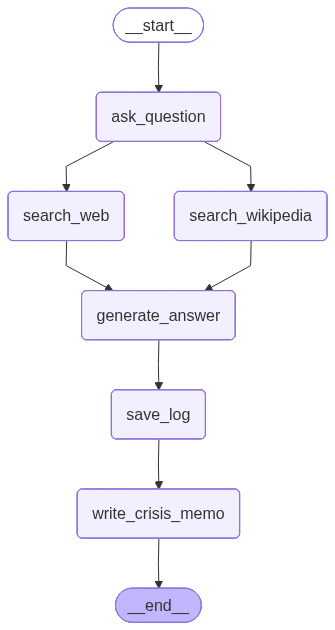

In [87]:
sim_builder = StateGraph(CrisisSimState)
sim_builder.add_node("ask_question", generate_question)
sim_builder.add_node("search_web", search_web)
sim_builder.add_node("search_wikipedia", search_wikipedia)
sim_builder.add_node("generate_answer", generate_answer)
sim_builder.add_node("save_log", save_simulation_log)
sim_builder.add_node("write_crisis_memo", write_crisis_memo)

sim_builder.add_edge(START, "ask_question")
sim_builder.add_edge("ask_question", "search_web")
sim_builder.add_edge("ask_question", "search_wikipedia")
sim_builder.add_edge("search_web", "generate_answer")
sim_builder.add_edge("search_wikipedia", "generate_answer")
sim_builder.add_edge("generate_answer", "save_log")
sim_builder.add_edge("save_log", "write_crisis_memo")
sim_builder.add_edge("write_crisis_memo", END)

memory = MemorySaver()
sim_graph = sim_builder.compile(checkpointer=memory)
display(Image(sim_graph.get_graph().draw_mermaid_png()))

In [88]:
specialists[0]

CrisisSpecialist(name='Dr. Emily Chen', role='Lead Medical Officer', agency='San Francisco Department of Public Health', focus='Coordinating medical response teams and managing field hospitals to treat earthquake-related injuries.')

In [89]:
from IPython.display import Markdown
from langchain_core.messages import HumanMessage

event_name = "Earthquake in San Francisco, 2025"
messages = [HumanMessage(f"Let's start the crisis simulation debrief for {event_name}.")]
thread = {"configurable": {"thread_id": "1"}}
simulation = sim_graph.invoke({"specialist": specialists[0], "messages": messages, "max_num_turns": 2}, thread)
Markdown(simulation["crisis_memos"][0])

# Earthquake Impact on Hospital Capacity in the Bay Area

## Key Findings

1. **Significant Loss of Hospital Capacity**: A simulated earthquake scenario predicts a substantial reduction in hospital capacity across the Bay Area, with an estimated loss of 8,165 hospital beds. This results in only 51% of total acute care beds remaining functional, with a standard deviation of 21%. The impact is uneven across the region, with hospitals within 20 km of the fault retaining only 25% functionality, compared to 51% at 20-40 km and 82% beyond 40 km.

2. **Structural and Non-Structural Vulnerabilities**: Hospitals with over half their buildings rated structurally poor (SPC ≤2) have 14% lower functionality, and those with poor non-structural ratings (NPC ≤ 3) have 17% lower functionality. Structural damage is more prevalent near the fault, while non-structural damage remains critical across the region.

3. **Seismic Compliance and Future Requirements**: By mid-2026, all California hospitals are expected to meet the state's life safety seismic standards. However, by 2030, hospitals must also ensure full functionality post-earthquake, including non-structural improvements to support 72 hours of operation. Currently, 62% of hospitals have at least one building that does not meet these 2030 standards.

4. **Legislative and Compliance Challenges**: Some hospitals face challenges in meeting seismic compliance deadlines, with potential closures if requirements are not met by 2030. Legislative measures, such as SB 869 and SB 1119, aim to provide relief and extend deadlines for certain hospitals.

## Data Sources

- **PMC Article**: Analysis of hospital capacity loss in the Bay Area following an earthquake scenario, detailing structural and non-structural vulnerabilities.
- **California Hospital Association**: Information on seismic compliance deadlines and legislative measures affecting hospital operations.
- **CalMatters**: Overview of seismic safety requirements and compliance status of California hospitals.
- **Wikipedia**: Contextual information on recent earthquakes in the Philippines, highlighting the impact on infrastructure and emergency response efforts.

This memo underscores the critical need for strategic planning and investment in hospital infrastructure to mitigate the impact of potential earthquakes and ensure continued access to healthcare services in the Bay Area.

#### Combine All (Map-Reduce Integration)

In [90]:
import operator
from typing import Annotated
from langgraph.types import Send

class CrisisPlanState(TypedDict):
    event_name: str
    max_specialists: int
    director_feedback: str
    specialists: List[CrisisSpecialist]
    crisis_memos: Annotated[list, operator.add]
    pre_briefing: str
    summary: str
    recommendation: str
    final_plan: str

def initiate_all_simulations(state: CrisisPlanState):
    event_name = state["event_name"]
    if state.get("director_feedback"):
        return "create_specialists"
    return [Send("run_simulation", {"specialist": s,
                                   "messages": [HumanMessage(
                                       content=f"Let's start the crisis simulation for {event_name}.")]})
            for s in state["specialists"]]

#### Write Pre-Briefing, Summary, and Recommendation

In [91]:
from langchain_core.messages import SystemMessage, HumanMessage

summary_instructions = """You are the Lead Coordinator summarizing crisis response memos into one cohesive plan for {event_name}."""

def write_summary(state: CrisisPlanState):
    memos = "\n\n".join(state["crisis_memos"])
    event_name = state["event_name"]
    sys = summary_instructions.format(event_name=event_name)
    result = llm.invoke([SystemMessage(content=sys), HumanMessage(content=memos)])
    return {"summary": result.content}

def write_pre_briefing(state: CrisisPlanState):
    memos = "\n\n".join(state["crisis_memos"])
    sys = f"You are the Lead Coordinator for {state['event_name']}. Write a short pre-response briefing (≈100 words)."
    result = llm.invoke([SystemMessage(content=sys), HumanMessage(content=memos)])
    return {"pre_briefing": result.content}

def write_recommendation(state: CrisisPlanState):
    memos = "\n\n".join(state["crisis_memos"])
    sys = f"You are concluding the plan for {state['event_name']}. Write a final recommendation (≈100 words)."
    result = llm.invoke([SystemMessage(content=sys), HumanMessage(content=memos)])
    return {"recommendation": result.content}

#### Final Report (Reduce Step)

In [92]:
def finalize_plan(state: CrisisPlanState):
    report = (
        "# Crisis Response Plan\n\n"
        + state["pre_briefing"] + "\n\n---\n\n"
        + "## Response Summary\n" + state["summary"] + "\n\n---\n\n"
        + "## Final Recommendations\n" + state["recommendation"]
    )
    return {"final_plan": report}

#### Build Full Graph

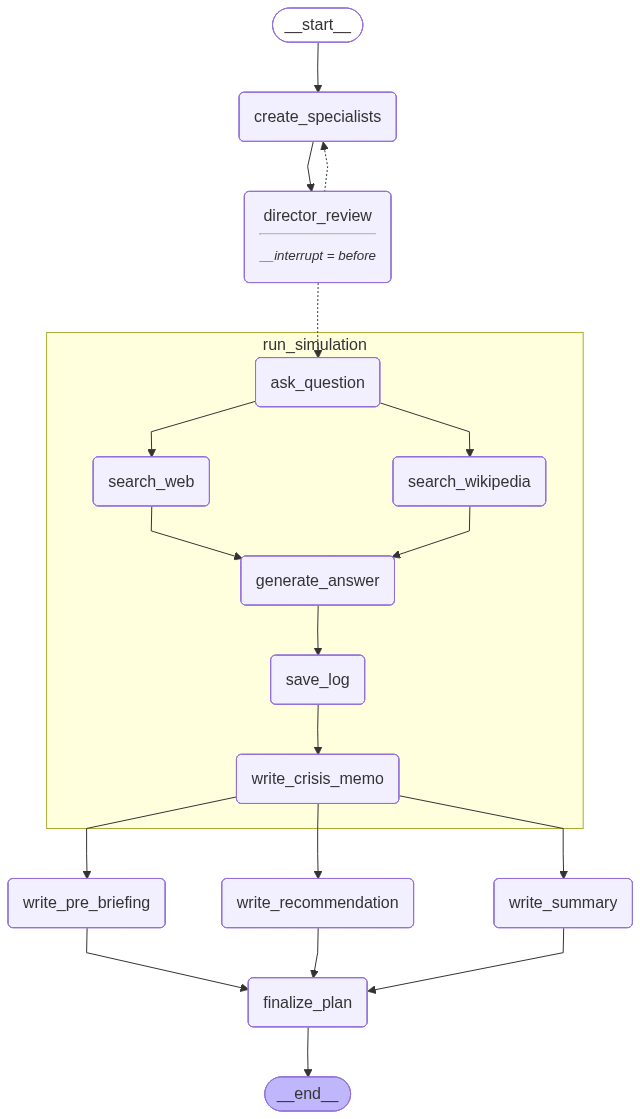

In [93]:
plan_builder = StateGraph(CrisisPlanState)
plan_builder.add_node("create_specialists", create_specialists)
plan_builder.add_node("director_review", human_feedback)
plan_builder.add_node("run_simulation", sim_graph)
plan_builder.add_node("write_summary", write_summary)
plan_builder.add_node("write_pre_briefing", write_pre_briefing)
plan_builder.add_node("write_recommendation", write_recommendation)
plan_builder.add_node("finalize_plan", finalize_plan)

plan_builder.add_edge(START, "create_specialists")
plan_builder.add_edge("create_specialists", "director_review")
plan_builder.add_conditional_edges("director_review", initiate_all_simulations,
                                   ["create_specialists", "run_simulation"])
plan_builder.add_edge("run_simulation", "write_summary")
plan_builder.add_edge("run_simulation", "write_pre_briefing")
plan_builder.add_edge("run_simulation", "write_recommendation")
plan_builder.add_edge(["write_summary", "write_pre_briefing", "write_recommendation"], "finalize_plan")
plan_builder.add_edge("finalize_plan", END)

memory = MemorySaver()
full_graph = plan_builder.compile(interrupt_before=["director_review"], checkpointer=memory)
display(Image(full_graph.get_graph(xray=1).draw_mermaid_png()))

#### Run the Full Crisis Response Workflow

In [99]:
max_specialists = 3
event_name = "Major Earthquake in San Francisco, 2025"
thread = {"configurable": {"thread_id": "1"}}

for event in full_graph.stream(
    {"event_name": event_name, "max_specialists": max_specialists},
    thread,
    stream_mode="values"
):
    specialists = event.get('specialists', '')
    if specialists:
        for specialist in specialists:
            print(specialist.persona)
            print("-" * 50)

Name: Dr. Emily Chen
Role: Lead Medical Coordinator
Agency: California Emergency Medical Services Authority
Focus: Coordinating medical response teams and ensuring adequate medical supplies and personnel are available at all affected sites.

--------------------------------------------------
Name: Mark Thompson
Role: Logistics Operations Manager
Agency: Federal Emergency Management Agency (FEMA)
Focus: Overseeing the distribution of essential resources such as food, water, and shelter to displaced residents and ensuring efficient supply chain management.

--------------------------------------------------
Name: Sarah Patel
Role: Communications Director
Agency: San Francisco Department of Emergency Management
Focus: Maintaining clear and accurate communication channels between emergency services, government agencies, and the public to provide timely updates and instructions.

--------------------------------------------------


#### Provide Human Feedback (like Crisis Director’s adjustment)

In [100]:
full_graph.update_state(
    thread, 
    {"director_feedback": "Add a data analyst focused on real-time resource tracking and logistics."}, 
    as_node="director_review"
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b6433-c861-6fdc-8002-e42c5665f96b'}}

#### Re-run the Workflow with Updated Specialists

In [101]:
for event in full_graph.stream(None, thread, stream_mode="values"):
    specialists = event.get('specialists', '')
    if specialists:
        for specialist in specialists:
            print(specialist.persona)
            print("-" * 50)

Name: Dr. Emily Chen
Role: Lead Medical Coordinator
Agency: California Emergency Medical Services Authority
Focus: Coordinating medical response teams and ensuring adequate medical supplies and personnel are available at all affected sites.

--------------------------------------------------
Name: Mark Thompson
Role: Logistics Operations Manager
Agency: Federal Emergency Management Agency (FEMA)
Focus: Overseeing the distribution of essential resources such as food, water, and shelter to displaced residents and ensuring efficient supply chain management.

--------------------------------------------------
Name: Sarah Patel
Role: Communications Director
Agency: San Francisco Department of Emergency Management
Focus: Maintaining clear and accurate communication channels between emergency services, government agencies, and the public to provide timely updates and instructions.

--------------------------------------------------
Name: Dr. Emily Chen
Role: Lead Medical Coordinator
Agency: S

#### Remove Further Feedback and Continue to Full Execution

In [102]:
full_graph.update_state(
    thread, 
    {"director_feedback": None}, 
    as_node="director_review"
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b6435-5475-60cc-8004-a3649e736024'}}

#### Stream Execution Nodes (for Debugging / Visualization)

In [103]:
for event in full_graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

--Node--
run_simulation
--Node--
run_simulation
--Node--
run_simulation
--Node--
write_recommendation
--Node--
write_pre_briefing
--Node--
write_summary
--Node--
finalize_plan


#### Display the Final Crisis Strategy Report

In [109]:
from IPython.display import Markdown

final_state = full_graph.get_state(thread)
report = final_state.values.get("final_plan")
Markdown(report)

# Crisis Response Plan

**Pre-Response Briefing: Major Earthquake in San Francisco, 2025**

As the Lead Coordinator for the San Francisco earthquake response, our immediate focus is on ensuring the safety and well-being of affected residents. The earthquake has significantly impacted infrastructure, with a notable reduction in hospital capacity and transportation disruptions. Our priorities include:

1. **Medical Response**: Deploy medical teams and resources to the most affected areas, particularly where hospital functionality is critically low.

2. **Resource Allocation**: Implement a coordinated logistics strategy to distribute essential supplies, including potable water and food, using multimodal transportation.

3. **Public Communication**: Provide clear and timely information to the public regarding available services and safety measures.

4. **Infrastructure Assessment**: Initiate rapid assessments of structural damage to prioritize repairs and ensure safe access to critical facilities.

Our coordinated efforts will focus on mitigating the immediate impact and setting the stage for recovery and rebuilding.

---

## Response Summary
# Cohesive Crisis Response Plan for Major Earthquake in San Francisco, 2025

## Overview

The San Francisco Bay Area faces a significant threat from seismic activity, as evidenced by the recent Hayward earthquake. This plan consolidates findings and recommendations from various crisis response memos to address the immediate and long-term needs following a major earthquake in 2025. The focus is on hospital capacity, logistics, preparedness, and resilience to ensure a coordinated and effective response.

## Key Challenges

1. **Hospital Capacity and Functionality**: The earthquake has severely impacted hospital infrastructure, with a significant reduction in available beds, particularly in Alameda County. Structural and non-structural damages have further compromised hospital operations.

2. **Logistics and Resource Allocation**: The disruption of transportation systems necessitates a robust logistics strategy to ensure the delivery of essential resources, including potable water and medical supplies, to affected areas.

3. **Infrastructure and Economic Impact**: The earthquake has caused extensive damage to infrastructure, necessitating immediate repair and long-term resilience planning.

4. **Preparedness and Resilience**: There is a critical need to enhance preparedness and resilience strategies to mitigate the impact of future seismic events.

## Strategic Response Plan

### Immediate Actions

1. **Hospital Resource Allocation**:
   - Deploy medical resources and personnel to the most affected areas, prioritizing Alameda County.
   - Establish temporary medical facilities and mobile units to compensate for lost hospital capacity.

2. **Logistics and Transportation**:
   - Implement a multimodal transportation strategy using air, marine, and surface routes to maintain supply chain integrity.
   - Develop temporary supply chains with staging areas to facilitate efficient resource distribution.

3. **Public Communication**:
   - Maintain transparent communication with the public regarding available medical services and resource distribution to manage expectations and reduce panic.

### Short-Term Actions

1. **Infrastructure Assessment and Repair**:
   - Conduct thorough assessments of damaged infrastructure, prioritizing repairs to critical transportation and hospital facilities.
   - Leverage federal assistance and international partnerships for recovery efforts.

2. **Emergency Support Functions**:
   - Activate regional emergency support functions to coordinate logistics, medical services, and urban search and rescue operations.

### Long-Term Actions

1. **Resilience Planning**:
   - Implement the Hazard and Climate Resilience (HCR) update's prioritized actions to enhance multi-hazard resilience.
   - Focus on infrastructure reinforcement, particularly for hospitals with poor structural and non-structural ratings.

2. **Preparedness Enhancement**:
   - Strengthen earthquake preparedness plans, emphasizing community education and infrastructure resilience.
   - Maintain continuous monitoring and assessment of seismic risks, incorporating lessons learned from recent global events.

3. **Strategic Resource Allocation**:
   - Develop a comprehensive emergency response plan that considers geographical disparities in hospital functionality and resource needs.

## Conclusion

The effective response to a major earthquake in San Francisco requires coordinated efforts across hospital capacity management, logistics, infrastructure repair, and resilience planning. By implementing these strategic actions, the Bay Area can mitigate the immediate impacts of the earthquake and enhance its preparedness for future seismic events.

---

## Final Recommendations
In conclusion, the comprehensive response to a major earthquake in San Francisco in 2025 requires a multi-faceted approach focusing on immediate resource allocation, infrastructure resilience, and strategic logistics. Prioritizing medical resources in severely impacted areas like Alameda County is crucial, alongside reinforcing hospital structures to withstand future seismic events. Implementing a multimodal transportation strategy will ensure efficient delivery of essential supplies, while coordinated logistics and emergency support functions will facilitate organized resource management. Strengthening preparedness through federal and international collaboration, continuous risk assessments, and public communication will enhance resilience and expedite recovery efforts.

### LangSmith Trace:

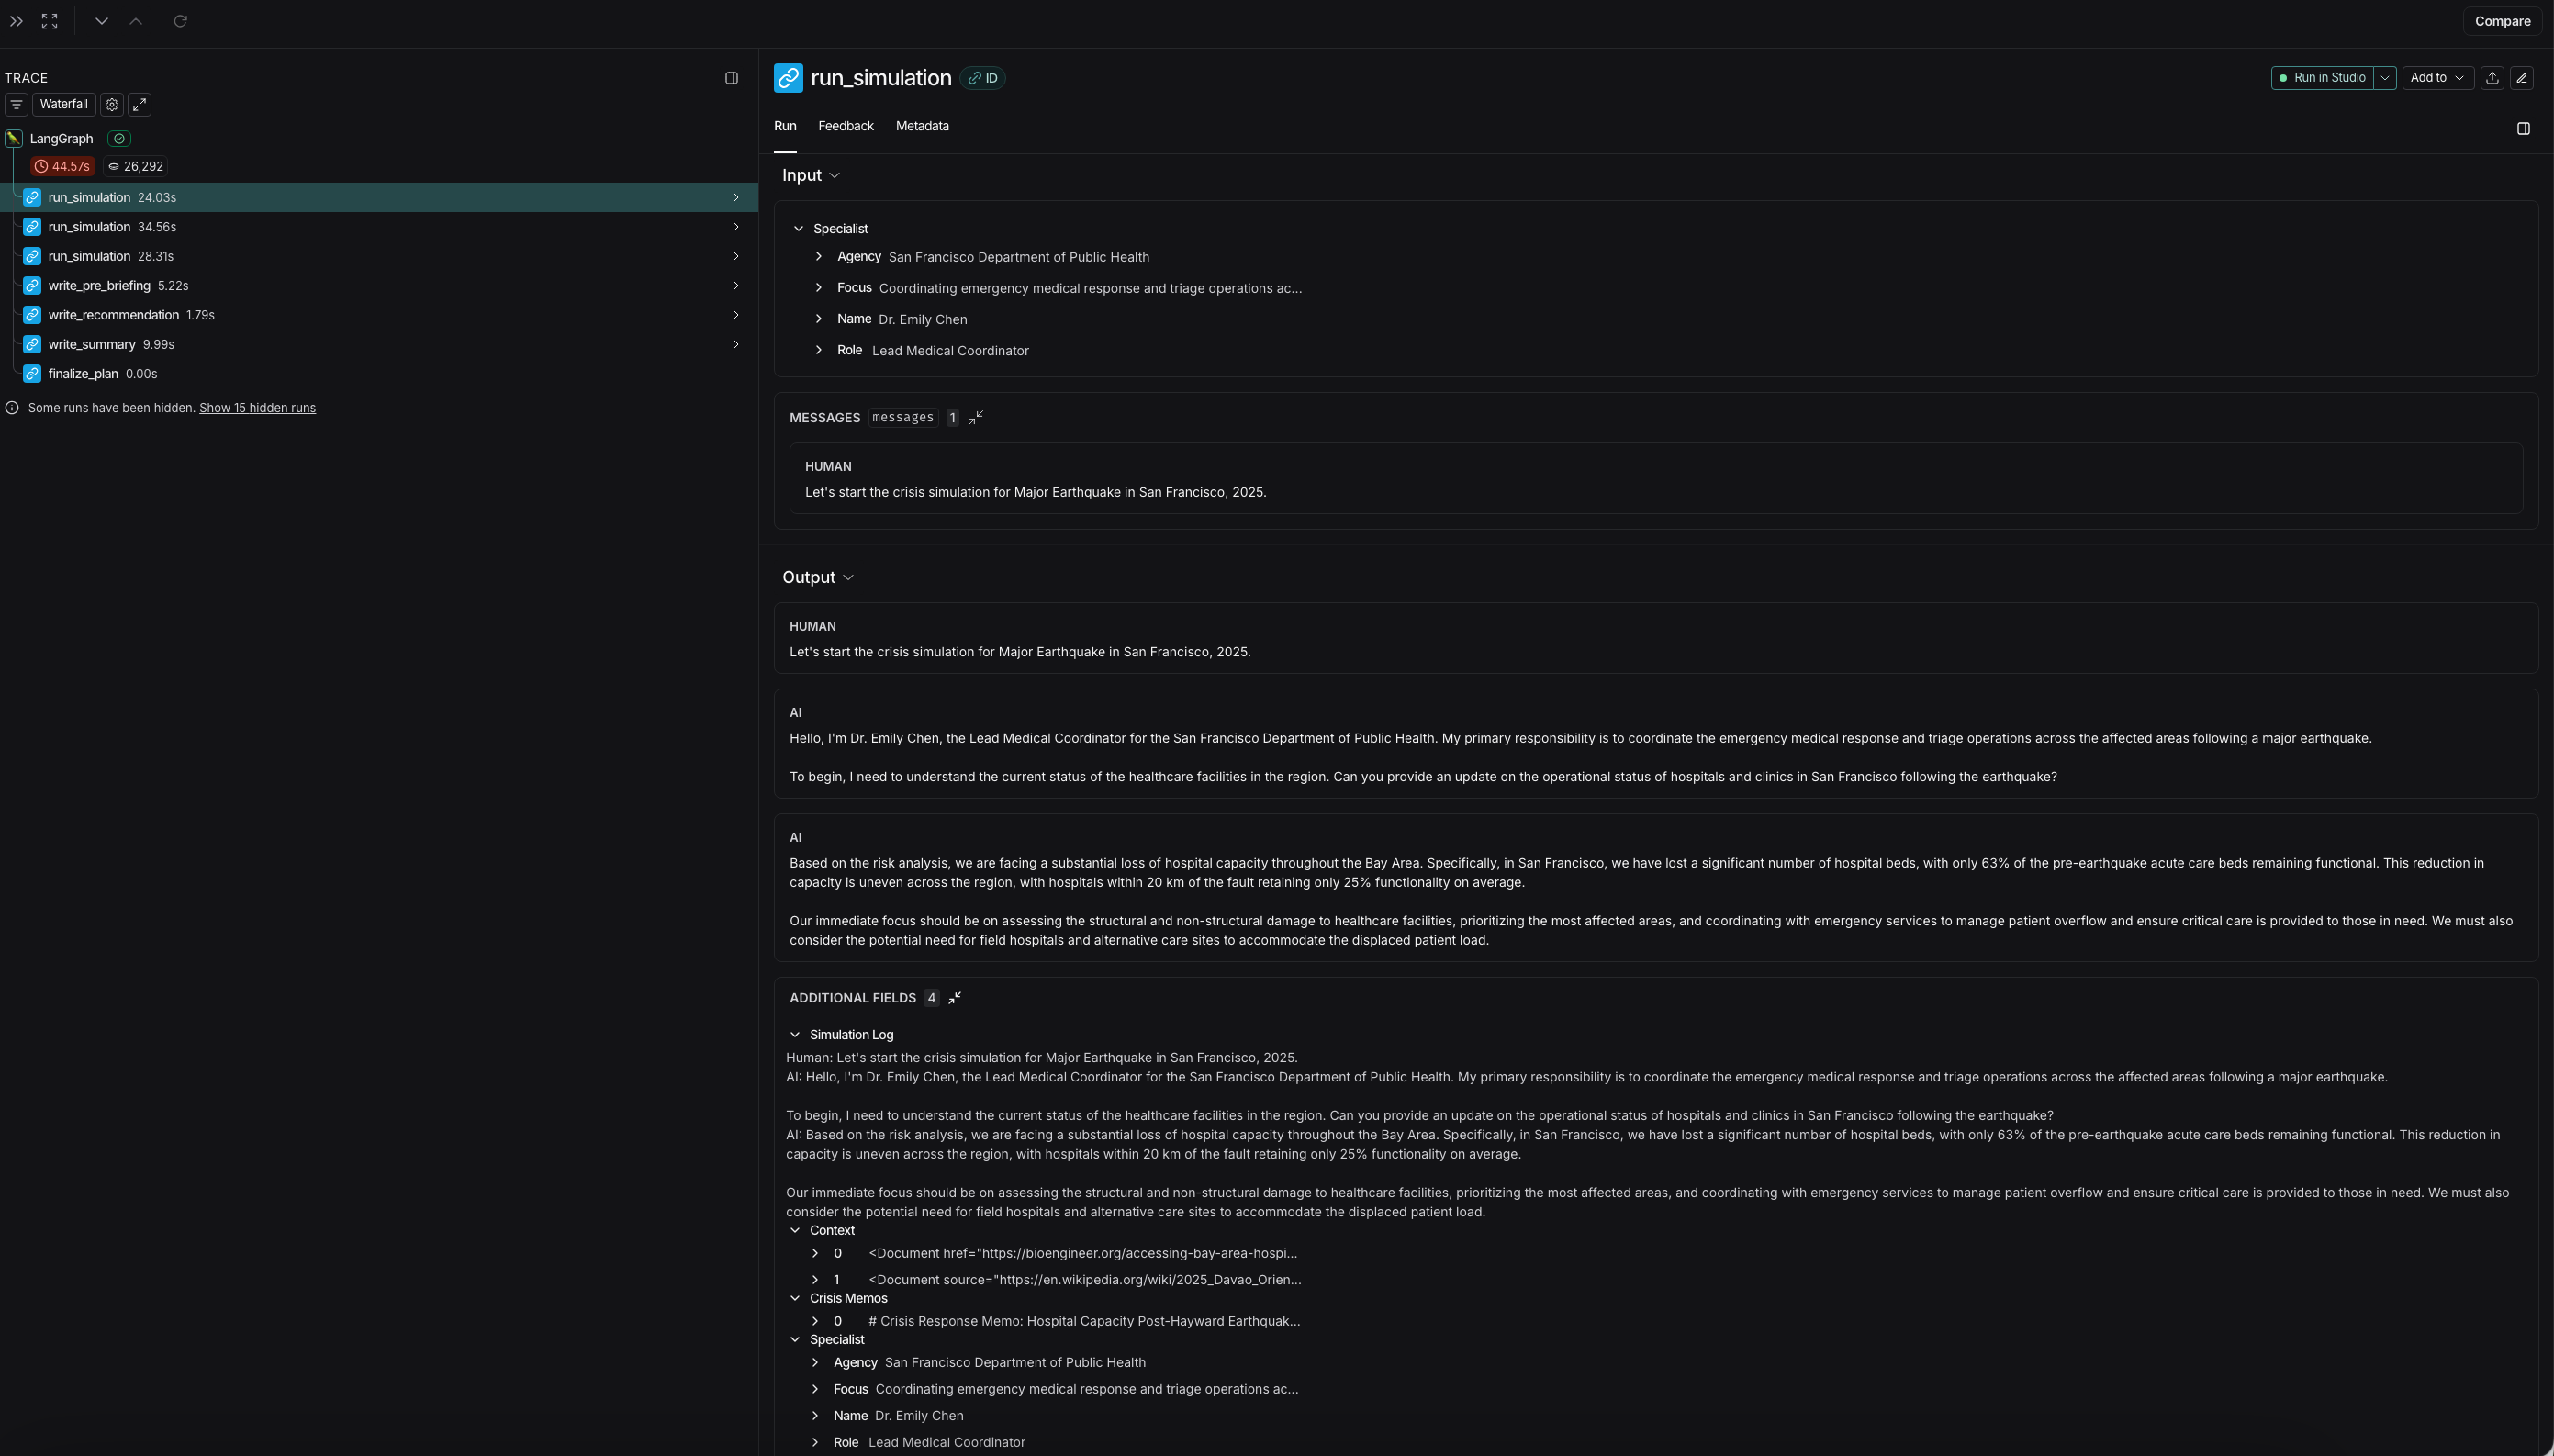